In [1]:
import time
import hydra
from hydra.utils import to_absolute_path
import torch
import sys
import os
import torch.nn as nn

import argparse

from dgl.dataloading import GraphDataLoader
import dgl
from omegaconf import DictConfig

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel

#project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', ''))
#sys.path.append(project_path)
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from python.create_dgl_dataset import TelemacDataset
from modulus.distributed.manager import DistributedManager
from modulus.launch.logging import (
    PythonLogger,
    RankZeroLoggingWrapper,
    initialize_wandb,
)
from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMeshGraphNet import MeshGraphNet


In [2]:
from hydra.utils import to_absolute_path

In [3]:
import numpy as np

In [4]:
def collate_fn(batch):
    # batch is a list of sequences
    # Each sequence is a list of graphs (of length sequence_length)
    # We want to batch the graphs at each time step across sequences

    sequence_length = len(batch[0])  # Assuming all sequences have the same length

    batched_graphs = []
    for t in range(sequence_length):
        graphs_at_t = [sequence[t] for sequence in batch]
        batched_graph = dgl.batch(graphs_at_t)
        batched_graphs.append(batched_graph)

    return batched_graphs

class TestRollout:
    def __init__(self, cfg: DictConfig, logger: PythonLogger):
        self.sequence_length = cfg.sequence_length  # Use sequence_length from config
        self.overlap = cfg.overlap 
        # Set device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"Using {self.device} device")
        
        # Instantiate dataset
        self.dataset = TelemacDataset(
            name="telemac_test",
            data_dir=to_absolute_path(cfg.data_dir),
            dynamic_data_files=[to_absolute_path(path) for path in cfg.dynamic_dir],
            split="test",
            ckpt_path=cfg.ckpt_path,
            normalize=True,
            sequence_length=self.sequence_length,
            overlap=self.sequence_length
        )
        # Instantiate dataloader
        self.dataloader = GraphDataLoader(
            self.dataset,
            batch_size=1,  
            shuffle=False,
            drop_last=False,
            collate_fn=collate_fn,  # Use custom collate_fn if defined
        )
        print(f"DataLoader Length: {len(self.dataloader)}")

        # Instantiate the model
        self.model = MeshGraphNet(
            cfg.num_input_features,
            cfg.num_edge_features,
            cfg.num_output_features,
            processor_size=cfg.mp_layers,
            hidden_dim_processor=64,
            hidden_dim_node_encoder=64,
            hidden_dim_edge_encoder=64,
            hidden_dim_node_decoder=64,
            do_concat_trick=cfg.do_concat_trick,
            num_processor_checkpoint_segments=cfg.num_processor_checkpoint_segments,
        )
        if cfg.jit:
            self.model = torch.jit.script(self.model).to(self.device)
        else:
            self.model = self.model.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Load checkpoint
        load_checkpoint(
            to_absolute_path(cfg.ckpt_path),
            models=self.model,
            device=self.device,
            epoch=2000,
        )
        self.model = self.model.to(self.device)
        
        # Get the stats needed to denormalize and normalize
        node_stats = self.dataset.node_stats
        self.h_u_v_i_0_mean = np.array([
            node_stats['h'].item(),
            node_stats['u'].item(),
            node_stats['v'].item()
        ])
        self.h_u_v_i_0_std = np.array([
            node_stats['h_std'].item(),
            node_stats['u_std'].item(),
            node_stats['v_std'].item()
        ])

        self.delta_h_u_v_i_diff_mean = np.array([
            node_stats['delta_h'].item(),
            node_stats['delta_u'].item(),
            node_stats['delta_v'].item()
        ])
        self.delta_h_u_v_i_diff_std = np.array([
            node_stats['delta_h_std'].item(),
            node_stats['delta_u_std'].item(),
            node_stats['delta_v_std'].item()
        ])
        
        # Define feature indices
        self.dynamic_feature_start = 6  # Adjust based on your actual feature indices
        self.dynamic_feature_end = 9  # Adjust based on your actual feature indices
        
    def predict(self, graph):
        """
        Predicts the next time step given the input graph.
        Denormalizes input features and predictions.
        Returns the denormalized predicted values.
        """
        with torch.no_grad():
            pred = self.model(
                graph.ndata['x'].to(self.device),
                graph.edata['x'].to(self.device),
                graph.to(self.device)
            ).cpu().numpy()
        
        # Denormalize data
        h_u_v_i_0 = self._denormalize_data(
            graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
            self.h_u_v_i_0_mean,
            self.h_u_v_i_0_std
        )

        # Compute predicted h, u, v at next time step
        h_u_v_i_1_pred = self._denormalize_data(
            pred,
            self.delta_h_u_v_i_diff_mean,
            self.delta_h_u_v_i_diff_std
        ) + h_u_v_i_0
                
        return h_u_v_i_1_pred, h_u_v_i_0
        
    def maj_mask(self, pred, next_step):
        """
        Updates predictions by applying boundary conditions from the next step.
        pred and next_step are normalized.
        """
        next_step_np = next_step.numpy()
        # Identify nodes with specific boundary conditions
        self.q_mask = (next_step_np[:, 0:4] == [0, 0, 1, 0]).all(axis=1)
        self.h_mask = (next_step_np[:, 0:4] == [0, 1, 0, 0]).all(axis=1)
        result = np.empty_like(next_step_np)
        
        # Copy static features from next_step
        result[:, 0:6] = next_step_np[:, 0:6]
        
        # Use predictions for dynamic features
        result[:, 6:9] = pred
        
        # Apply boundary conditions
        result[self.q_mask, 6:9] = next_step_np[self.q_mask, 6:9]
        result[self.h_mask, 6:7] = next_step_np[self.h_mask, 6:7]
        return result 
    
    def predict_unroll(self, unroll_steps=1):
        predict = []
        groundtruth = []
        origin = []
        for sequence in self.dataloader:
            # sequence is now a list of graphs
            sequence_length = len(sequence)
            if sequence_length < unroll_steps + 1:
                continue  # Skip sequences that are too short

            graph = sequence[0].clone()  # Start from the first graph in the sequence
            h_u_v_i_0 = None  # To store initial input at time t=0
            for i in range(unroll_steps):
                next_graph = sequence[i + 1]
                h_u_v_i_1_pred, h_u_v_i_0 = self.predict(graph)

                if i == 0:
                    origin.append(h_u_v_i_0)

                #noise_filter = h_u_v_i_1_pred[:, 0] < 5e-3
                #h_u_v_i_1_pred[noise_filter, :] = 0.0

                # Normalize the prediction to transfer to the next graph
                h_u_v_i_1_pred_norm = self._normalize_data(
                    h_u_v_i_1_pred,
                    self.h_u_v_i_0_mean,
                    self.h_u_v_i_0_std
                )

                # Apply boundary conditions
                next_step_result = self.maj_mask(
                    h_u_v_i_1_pred_norm,
                    next_graph.ndata['x']
                )

                # Update the graph's node features for the next prediction
                graph.ndata['x'] = torch.tensor(next_step_result, dtype=torch.float32)

            predict.append(h_u_v_i_1_pred)
            # Denormalize ground truth from next_graph
            groundtruth.append(self._denormalize_data(
                next_graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
                self.h_u_v_i_0_mean,
                self.h_u_v_i_0_std
            ))

        return predict, groundtruth, origin

    def _denormalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return tensor * std + mean 
    
    def _normalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return (tensor - mean) / std
    
    def get_raw_data(self, idx):
        self.pred_i = [var[:, idx] for var in self.pred]
        self.exact_i = [var[:, idx] for var in self.exact]
        return self.graphs, self.faces, self.pred_i, self.exact_i



In [5]:
import hydra
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf

import time 

# Initialize Hydra and set the configuration directory
with initialize(config_path="../bin/conf"):
    logger = PythonLogger("main")  # General python logger
    logger.file_logging()
    # Compose the configuration using the config name
    cfg = compose(config_name="Config1Group3Shortx16MultiTest")
    
    # Now call the training function with the composed config
    test = TestRollout(cfg,logger)
    
    predict,groundtruth,origin = test.predict_unroll(unroll_steps=12)
    

/tmp/ipykernel_2384724/3097536884.py:8: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../bin/conf"):
[18:22:20 - main - INFO] Using cuda device


Loading normalization statistics...
DataLoader Length: 57


[18:22:20 - checkpoint - INFO] Loaded model state dictionary /work/m24046/m24046mrcr/new_tests_Group3/config1_short_x16_multimesh/MeshGraphNet.0.2000.mdlus to device cuda
[18:22:20 - checkpoint - INFO] Loaded checkpoint file /work/m24046/m24046mrcr/new_tests_Group3/config1_short_x16_multimesh/checkpoint.0.2000.pt to device cuda


In [6]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info

#mesh_list = ['/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf']
mesh_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Mesh16_corrige.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

In [7]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info

mesh_list = ['/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf']
#mesh_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70/maillage_3.slf']
res_mesh_fine = TelemacFile(mesh_list[0])
X_fine,triangles_fine = add_mesh_info(res_mesh_fine)

In [8]:
import pickle
from scipy.interpolate import griddata

fine_values = []
list_of_test_files = [
    '/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_1600_Group_3_peak_1600_0_0-80.pkl',
    '/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_2200_Group_3_peak_2200_0_0-80.pkl',
    '/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_3200_Group_3_peak_3200_0_0-80.pkl'
]

In [9]:
sequence_length = 13
overlap = 13
sequences = []
for file_path in list_of_test_files:
    with open(file_path, 'rb') as f:
        dynamic_data = pickle.load(f)
        step = max(1, sequence_length - overlap)
        for i in range(0, len(dynamic_data) - sequence_length + 1, step):
            sequence = dynamic_data[i:i + sequence_length]
            sequences.append(sequence)

In [10]:
fine_gd = []
fine_ori = []
for seq in sequences : 
    a,b = seq[-1]
    correct = a+b
    fine_gd.append(correct)
    fine_ori.append(seq[0][0])

In [11]:
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import copy

### Projection

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

epsilon = 5e-2

def interpolate_and_classify(X, data, xi, yi, epsilon):
    """ Interpolate data and classify pixels based on epsilon """
    interp_data = griddata((X[:, 0], X[:, 1]), data[:, 0], (xi, yi), method='linear')
    interp_data = np.nan_to_num(interp_data,0.0)
    binary_data = np.zeros_like(interp_data)
    binary_data[interp_data >= epsilon] = 1  # Positive
    return interp_data, binary_data

def classify_prediction(pred_interp, gd_interp, epsilon):
    """ Classify pixels based on prediction and groundtruth """
    tp = (pred_interp >= epsilon) & (gd_interp >= epsilon)
    fn = (pred_interp < epsilon) & (gd_interp >= epsilon)
    fp = (pred_interp >= epsilon) & (gd_interp < epsilon)
    
    color_codes = np.zeros_like(pred_interp)
    color_codes[tp] = 1  # True Positive - Blue
    color_codes[fn] = 2  # False Negative - Red
    color_codes[fp] = 3  # False Positive - Green
    
    return color_codes


def plot_data(ax, data, title, cmap, bounds, norm):
    """ Plot interpolated data with a given colormap """
    ax.set_title(title)
    ax.pcolormesh(xi, yi, data, shading='auto', cmap=cmap, norm=norm)
    ax.set_aspect('equal')

In [13]:
from matplotlib.tri import Triangulation
from scipy.spatial import Delaunay

fine_data = fine_gd

# Prepare grid points
# Define your domain bounds and grid resolution
xmin = min(X[:, 0].min(), X_fine[:, 0].min())
xmax = max(X[:, 0].max(), X_fine[:, 0].max())
ymin = min(X[:, 1].min(), X_fine[:, 1].min())
ymax = max(X[:, 1].max(), X_fine[:, 1].max())
Nx, Ny = 700, 700  # Adjust as needed

grid_x, grid_y = np.mgrid[xmin:xmax:Nx*1j, ymin:ymax:Ny*1j]
grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T  # Shape: (n_grid_points, 2)

# Create a mask for the domain using the fine mesh triangulation
triangulation_mask = Triangulation(X_fine[:, 0], X_fine[:, 1], triangles=triangles_fine)
mask = triangulation_mask.get_trifinder()(grid_x, grid_y) != -1  # True inside the domain
mask_flat = mask.ravel()

# Precompute triangulations
tri_fine = Delaunay(X_fine)
tri_coarse = Delaunay(X)

# Compute simplex indices for fine and coarse meshes
simplex_indices_fine = tri_fine.find_simplex(grid_points)
simplex_indices_coarse = tri_coarse.find_simplex(grid_points)

# Apply the mask to simplex indices
simplex_indices_fine_masked = np.where(mask_flat, simplex_indices_fine, -1)
simplex_indices_coarse_masked = np.where(mask_flat, simplex_indices_coarse, -1)

# Identify valid points inside the domain and within a simplex
valid_fine = simplex_indices_fine_masked >= 0
valid_coarse = simplex_indices_coarse_masked >= 0

# Compute barycentric coordinates for valid points on fine mesh
transform_fine = tri_fine.transform[simplex_indices_fine_masked[valid_fine], :2]
offset_fine = tri_fine.transform[simplex_indices_fine_masked[valid_fine], 2]
delta_fine = grid_points[valid_fine] - offset_fine
bary_coords_fine = np.einsum('ijk,ik->ij', transform_fine, delta_fine)
bary_coords_fine = np.hstack((bary_coords_fine, 1 - bary_coords_fine.sum(axis=1, keepdims=True)))

# Compute barycentric coordinates for valid points on coarse mesh
transform_coarse = tri_coarse.transform[simplex_indices_coarse_masked[valid_coarse], :2]
offset_coarse = tri_coarse.transform[simplex_indices_coarse_masked[valid_coarse], 2]
delta_coarse = grid_points[valid_coarse] - offset_coarse
bary_coords_coarse = np.einsum('ijk,ik->ij', transform_coarse, delta_coarse)
bary_coords_coarse = np.hstack((bary_coords_coarse, 1 - bary_coords_coarse.sum(axis=1, keepdims=True)))

# Interpolation function
def interpolate_values(tri_simplices, simplex_indices, bary_coords, values, valid_indices, n_grid_points):
    n_variables = values.shape[1]
    result = np.full((n_grid_points, n_variables), np.nan)
    for idx, i in enumerate(valid_indices):
        simplex_index = simplex_indices[idx]
        indices = tri_simplices[simplex_index]
        bc = bary_coords[idx]
        v = values[indices]
        interpolated_value = np.dot(bc, v)
        result[i] = interpolated_value
    return result

# Number of grid points
n_grid_points = grid_points.shape[0]

# Interpolate fine data
fine_gd_grid = []
for fine_data in fine_gd:
    interpolated_values = interpolate_values(
        tri_fine.simplices,
        simplex_indices_fine_masked[valid_fine],
        bary_coords_fine,
        fine_data,
        np.where(valid_fine)[0],
        n_grid_points
    )
    # Reshape to grid shape and number of variables
    interpolated_values = interpolated_values.reshape((grid_x.shape[0], grid_x.shape[1], -1))
    fine_gd_grid.append(interpolated_values)

# Interpolate coarse predictions
projected_predi = []
for pred in predict:
    interpolated_values = interpolate_values(
        tri_coarse.simplices,
        simplex_indices_coarse_masked[valid_coarse],
        bary_coords_coarse,
        pred,
        np.where(valid_coarse)[0],
        n_grid_points
    )
    # Reshape to grid shape and number of variables
    interpolated_values = interpolated_values.reshape((grid_x.shape[0], grid_x.shape[1], -1))
    projected_predi.append(interpolated_values)

In [14]:
# Interpolate fine data
fine_ori_grid = []
for fine_data in fine_ori:
    interpolated_values = interpolate_values(
        tri_fine.simplices,
        simplex_indices_fine_masked[valid_fine],
        bary_coords_fine,
        fine_data,
        np.where(valid_fine)[0],
        n_grid_points
    )
    # Reshape to grid shape and number of variables
    interpolated_values = interpolated_values.reshape((grid_x.shape[0], grid_x.shape[1], -1))
    fine_ori_grid.append(interpolated_values)

In [110]:
print(projected_predi[0].shape)
print(len(projected_predi))
print(fine_gd_grid[0].shape)
print(len(fine_gd_grid))

(700, 700, 3)
57
(700, 700, 3)
57


In [15]:
mask = np.load("./datas/mask_init.npy").reshape((700,700))

In [16]:
#print("L1 Errors (per variable):")
#for idx, error in enumerate(L1_errors):
#    print(f"Sample {idx}: L1 Error = {error}")

# Compute CSI only on the 0th dimension (h variable)
def calculate_csi(predictions, observations, epsilon):
    binary_predictions = (predictions >= epsilon).astype(int)
    binary_observations = (observations >= epsilon).astype(int)
    TP = np.sum((binary_predictions == 1) & (binary_observations == 1))
    FP = np.sum((binary_predictions == 1) & (binary_observations == 0))
    FN = np.sum((binary_predictions == 0) & (binary_observations == 1))
    csi = TP / (TP + FP + FN)
    return csi

In [113]:
data_index = 0 #0 pour l'eau, 1 et 2 pour les vitesses 

L1_errors_in = []
for projected_pred, fine_grid in zip(projected_predi, fine_gd_grid):
    # Ensure both grids have the same shape and handle NaNs
    gd = fine_grid[mask,data_index]
    pred = projected_pred[mask,data_index]
    difference = np.nan_to_num(gd - pred, nan=0.0)
    # Compute mean absolute error for each variable
    L1_error = np.mean(np.abs(difference))  # Mean over grid points
    L1_errors_in.append(L1_error)

In [114]:
L1_errors_out = []
for projected_pred, fine_grid in zip(projected_predi, fine_gd_grid):
    # Ensure both grids have the same shape and handle NaNs
    gd = fine_grid[~(mask),data_index]
    pred = projected_pred[~(mask),data_index]
    difference = np.nan_to_num(gd - pred, nan=0.0)
    # Compute mean absolute error for each variable
    L1_error = np.mean(np.abs(difference))  # Mean over grid points
    L1_errors_out.append(L1_error)

In [115]:
print(np.array(L1_errors_in))

[0.4948622  0.4737313  0.46366779 0.4537486  0.43749837 0.42621022
 0.4208058  0.42467457 0.40171114 0.38091732 0.37421574 0.37676273
 0.37236817 0.37289998 0.37909211 0.38800391 0.39217316 0.3968265
 0.40517925 0.49148181 0.48137057 0.48378148 0.47287513 0.46904462
 0.44455522 0.43965561 0.43169788 0.41528835 0.41154059 0.40700175
 0.39819636 0.39703964 0.39842469 0.40003313 0.39841299 0.40675594
 0.40848277 0.41063142 0.50215799 0.50151766 0.51327343 0.50413651
 0.51845697 0.50521623 0.50367773 0.48767356 0.45994356 0.46657967
 0.44826034 0.43537051 0.42935253 0.42307728 0.42417514 0.42378817
 0.41598078 0.42244388 0.42776644]


In [116]:
print(L1_errors_out)

[0.037250318440951904, 0.04146086666288538, 0.04090384987217723, 0.04415540624020459, 0.04307337303382157, 0.03949742456504658, 0.042734842835166875, 0.039458636853015976, 0.044990590891807895, 0.055767665087314185, 0.05960665958127104, 0.05680799778789964, 0.0482021615271734, 0.0483423801163487, 0.04126866936173066, 0.03721939189445642, 0.03688929939188133, 0.03506349665294201, 0.033760012878244164, 0.056733526413394575, 0.05490586032889662, 0.06395253423907846, 0.06435024901026233, 0.06016460207225549, 0.06125501535933415, 0.060130263583105546, 0.06089779568425884, 0.059821515554008456, 0.060882519609042285, 0.058676902683098824, 0.0542084586583561, 0.0510844285531574, 0.05134397825434897, 0.046775720491437606, 0.04808211955510864, 0.04472622174087008, 0.04346035572540512, 0.04520778339522243, 0.0869486251642406, 0.08919571358450518, 0.10193603712959268, 0.10161568307608208, 0.10066701550906922, 0.1028677440368434, 0.10794609472648216, 0.10169441232936326, 0.08967655202312745, 0.0943

In [117]:
np.save("./datas/L1_errors_in_x16.npy", np.array(L1_errors_in))
np.save("./datas/L1_errors_out_x16.npy", np.array(L1_errors_out))

In [118]:
epsilon = 0.05  # Set your threshold
CSI_scores_in = []
for idx, (projected_pred, fine_grid) in enumerate(zip(projected_predi, fine_gd_grid)):
    # Extract the 0th dimension (h variable)
    pred_h = projected_pred[mask, 0]
    fine_h = fine_grid[mask, 0]
    # Flatten the arrays and remove NaNs
    pred_flat = pred_h.flatten()
    obs_flat = fine_h.flatten()
    valid_idx = ~np.isnan(pred_flat) & ~np.isnan(obs_flat)
    csi = calculate_csi(pred_flat[valid_idx], obs_flat[valid_idx], epsilon)
    CSI_scores_in.append(csi)


In [119]:
epsilon = 0.05  # Set your threshold
CSI_scores_out = []
for idx, (projected_pred, fine_grid) in enumerate(zip(projected_predi, fine_gd_grid)):
    # Extract the 0th dimension (h variable)
    pred_h = projected_pred[~mask, 0]
    fine_h = fine_grid[~mask, 0]
    # Flatten the arrays and remove NaNs
    pred_flat = pred_h.flatten()
    obs_flat = fine_h.flatten()
    valid_idx = ~np.isnan(pred_flat) & ~np.isnan(obs_flat)
    csi = calculate_csi(pred_flat[valid_idx], obs_flat[valid_idx], epsilon)
    CSI_scores_out.append(csi)

In [17]:
epsilon = 0.05  # Set your threshold
CSI_scores_out_id = []
for idx, (projected_pred, fine_grid) in enumerate(zip(fine_ori_grid, fine_gd_grid)):
    # Extract the 0th dimension (h variable)
    pred_h = projected_pred[~mask, 0]
    fine_h = fine_grid[~mask, 0]
    # Flatten the arrays and remove NaNs
    pred_flat = pred_h.flatten()
    obs_flat = fine_h.flatten()
    valid_idx = ~np.isnan(pred_flat) & ~np.isnan(obs_flat)
    csi = calculate_csi(pred_flat[valid_idx], obs_flat[valid_idx], epsilon)
    CSI_scores_out_id.append(csi)

In [18]:
np.save("./datas/CSI_out_id.npy", np.array(CSI_scores_out_id))

In [120]:
np.save("./datas/CSI_in_x16.npy", np.array(CSI_scores_in))
np.save("./datas/CSI_out_x16.npy", np.array(CSI_scores_out))

In [121]:
print(np.mean(CSI_scores_out))

0.5925332155654777


In [122]:
print(np.mean(CSI_scores_in))

0.9979985988024818


In [124]:
cs1 = np.load("./datas/CSI_out_x1.npy")
cs2 = np.load("./datas/CSI_out_x2.npy")
cs4 = np.load("./datas/CSI_out_x4.npy")
cs8 = np.load("./datas/CSI_out_x8.npy")
cs16 = np.load("./datas/CSI_out_x16.npy")

<Figure size 640x480 with 0 Axes>

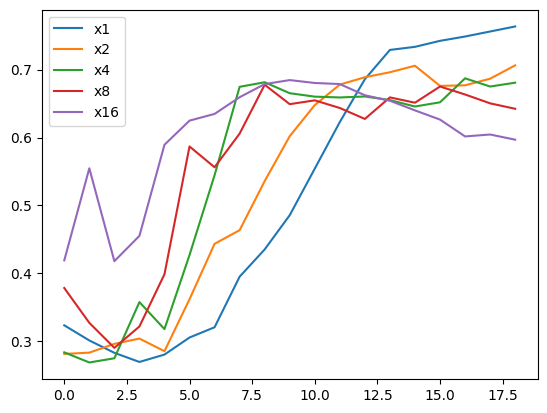

<Figure size 640x480 with 0 Axes>

In [125]:
plt.figure()
i=1
plt.plot(cs1[19*i:(i+1)*19],label='x1')
plt.plot(cs2[19*i:(i+1)*19],label='x2')
plt.plot(cs4[19*i:(i+1)*19],label='x4')
plt.plot(cs8[19*i:(i+1)*19],label='x8')
plt.plot(cs16[19*i:(i+1)*19],label='x16')

plt.legend()
plt.figure()

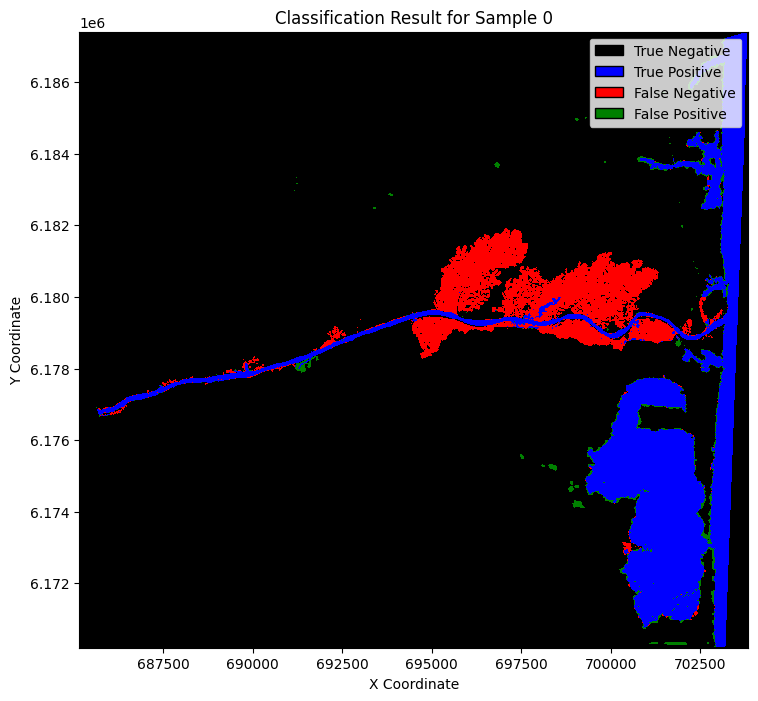

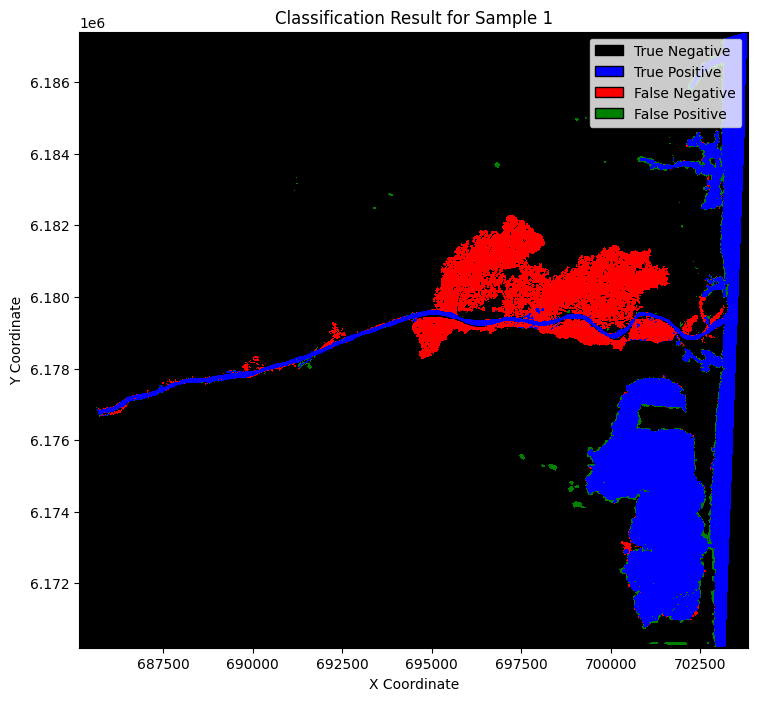

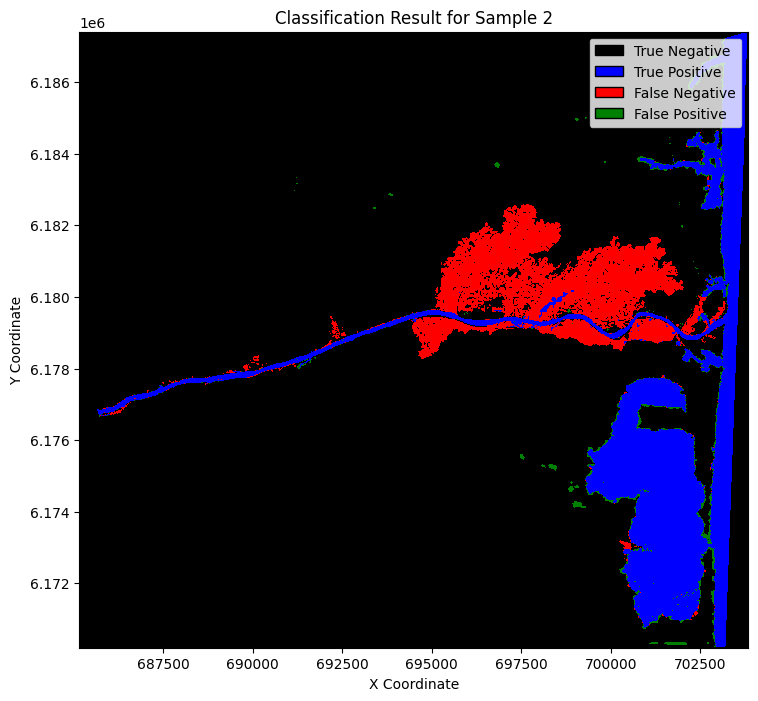

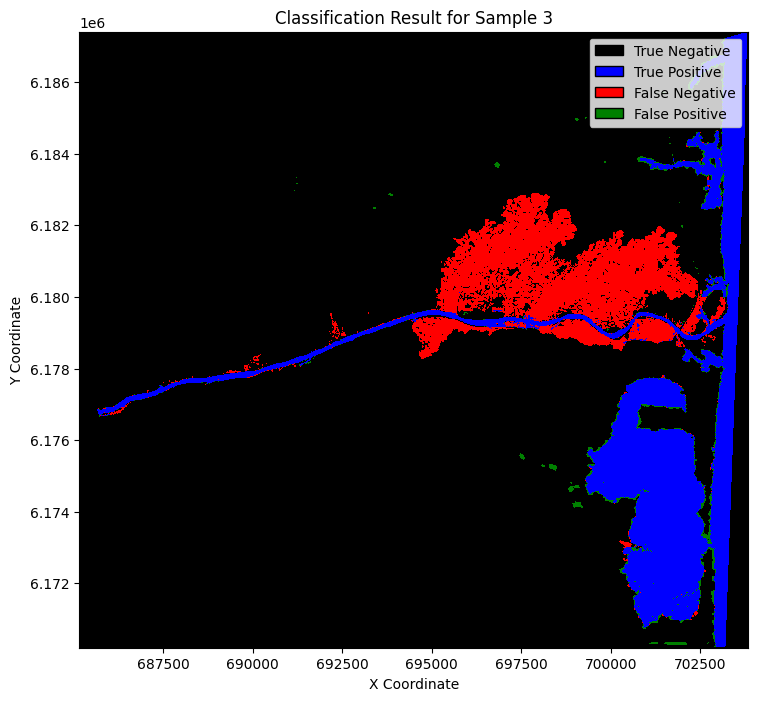

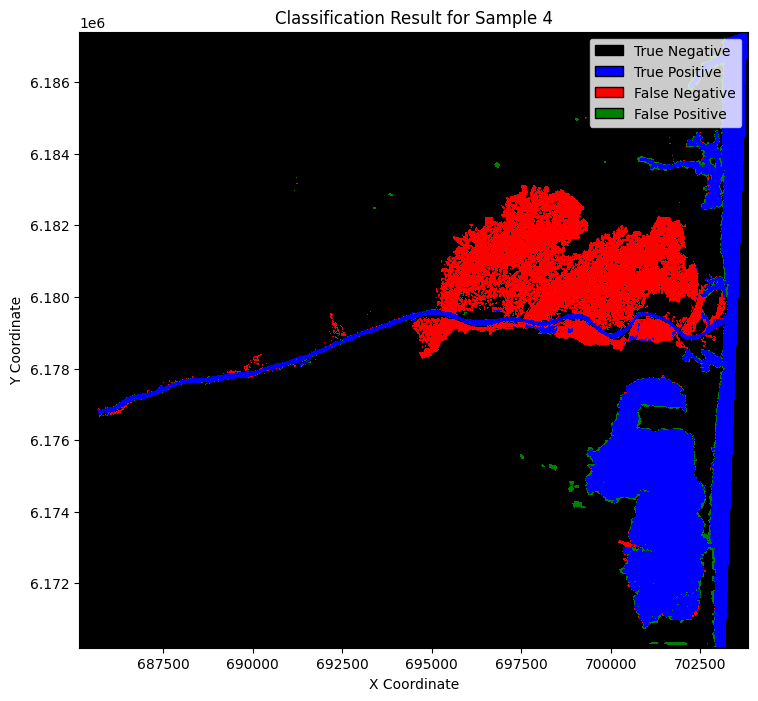

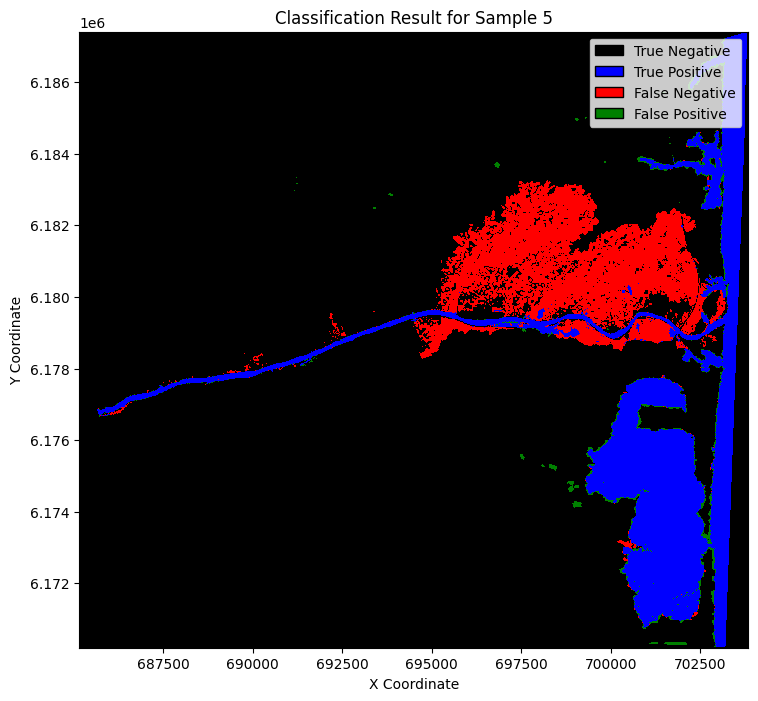

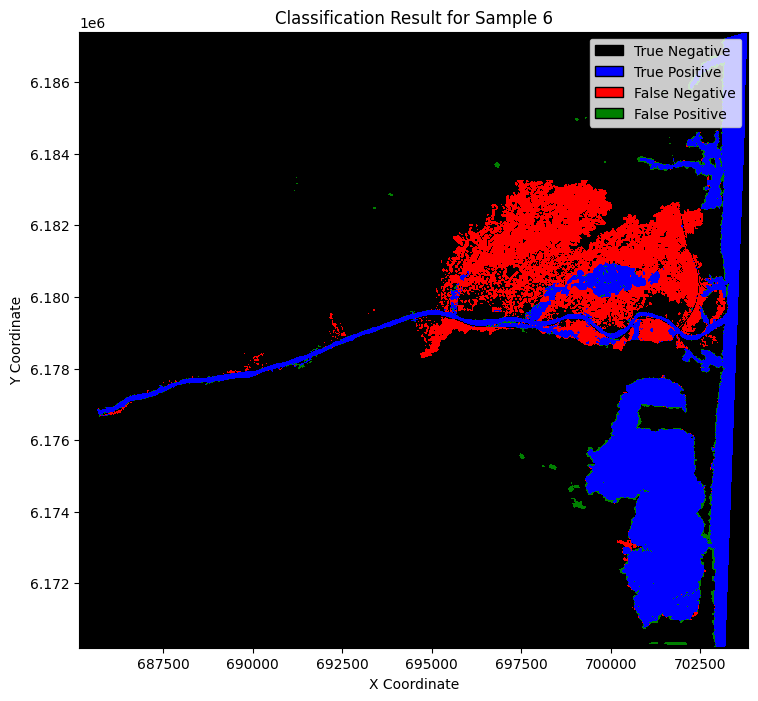

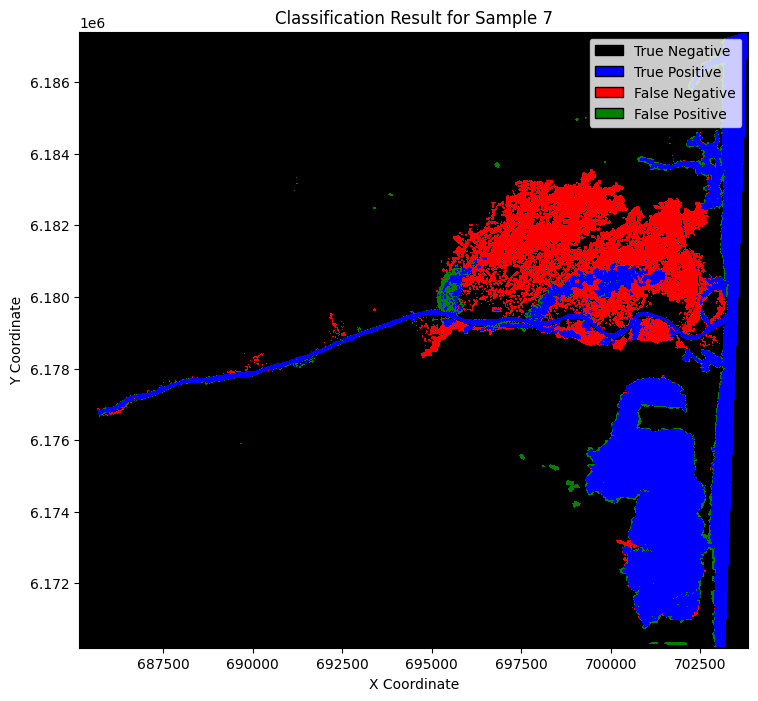

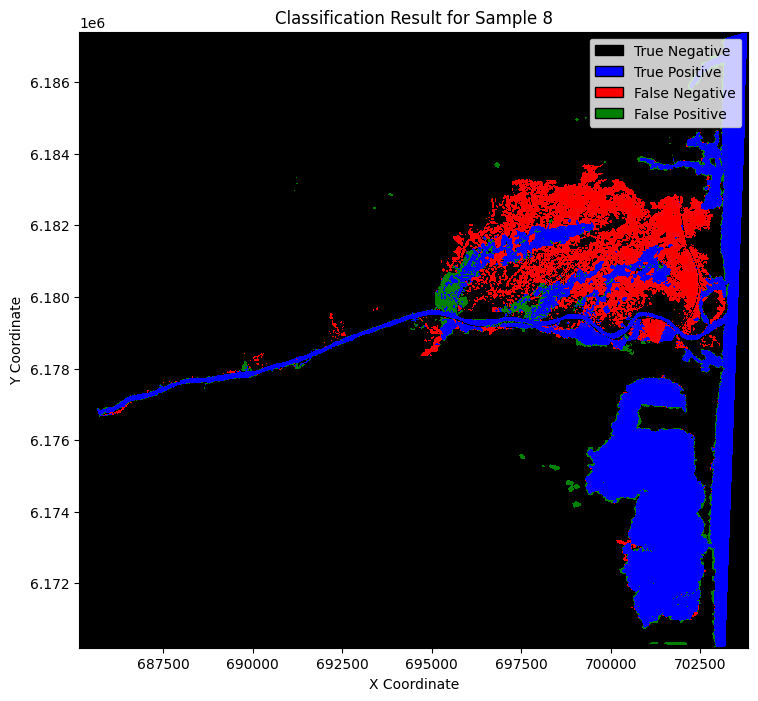

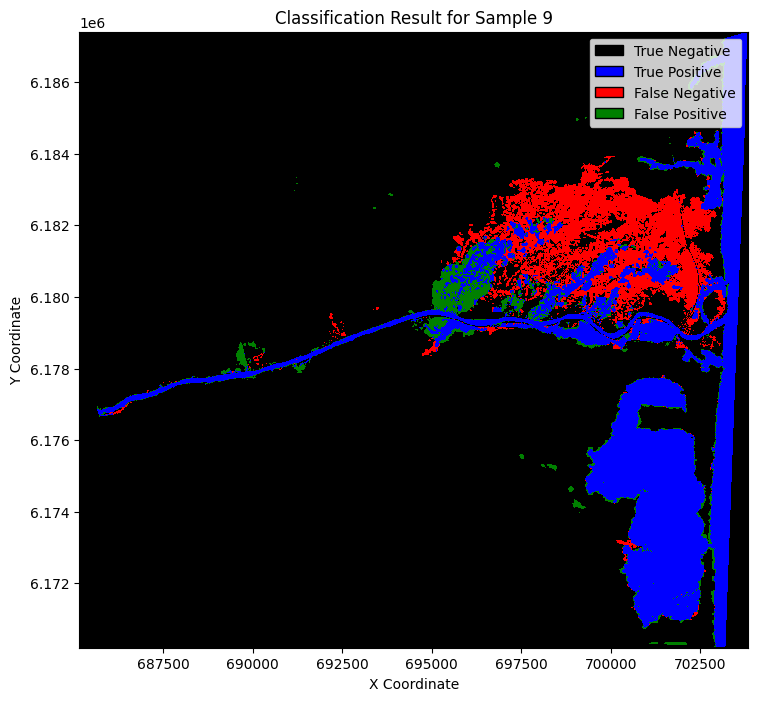

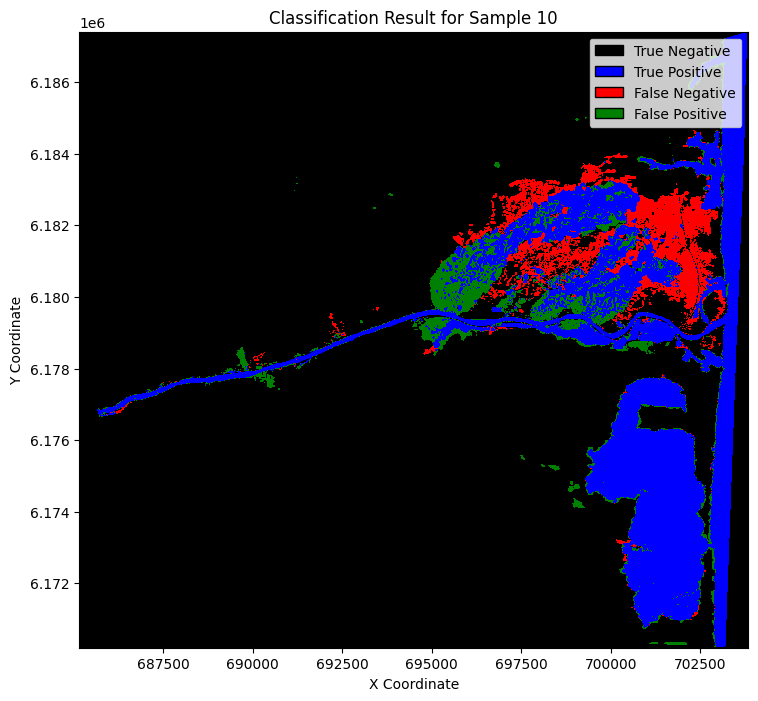

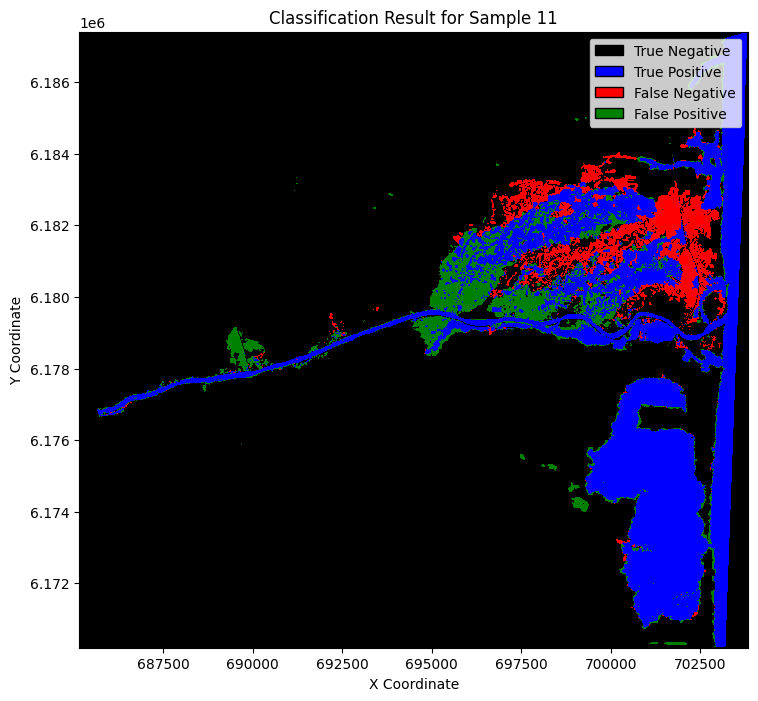

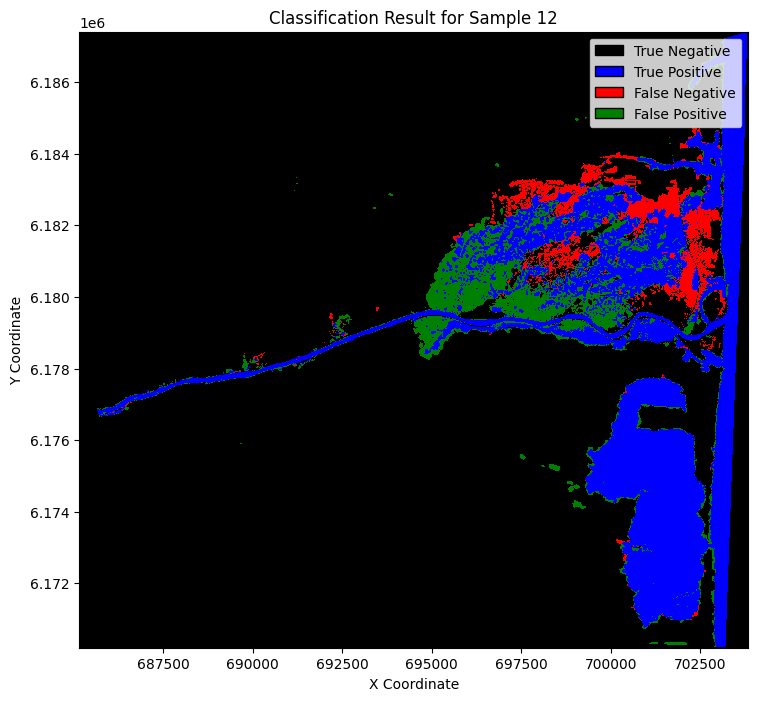

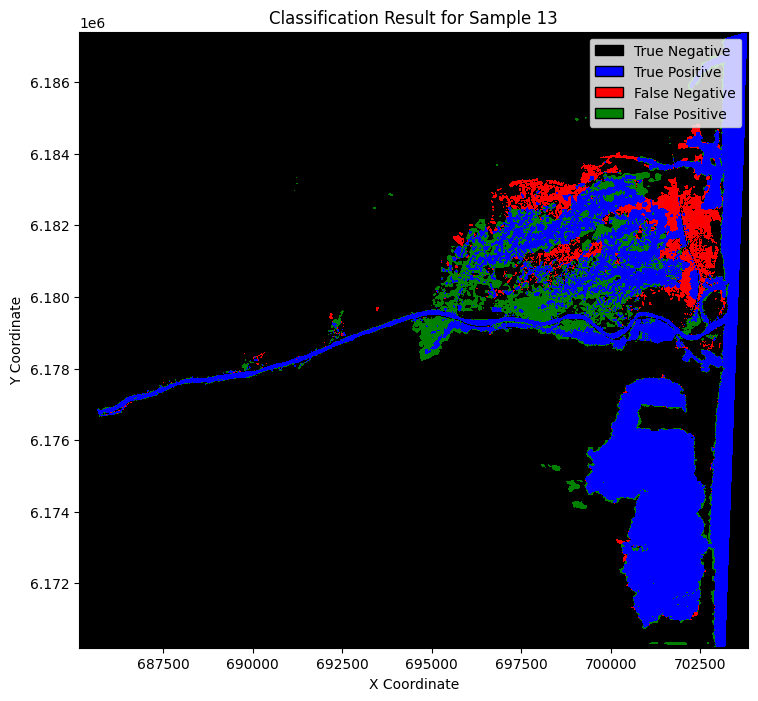

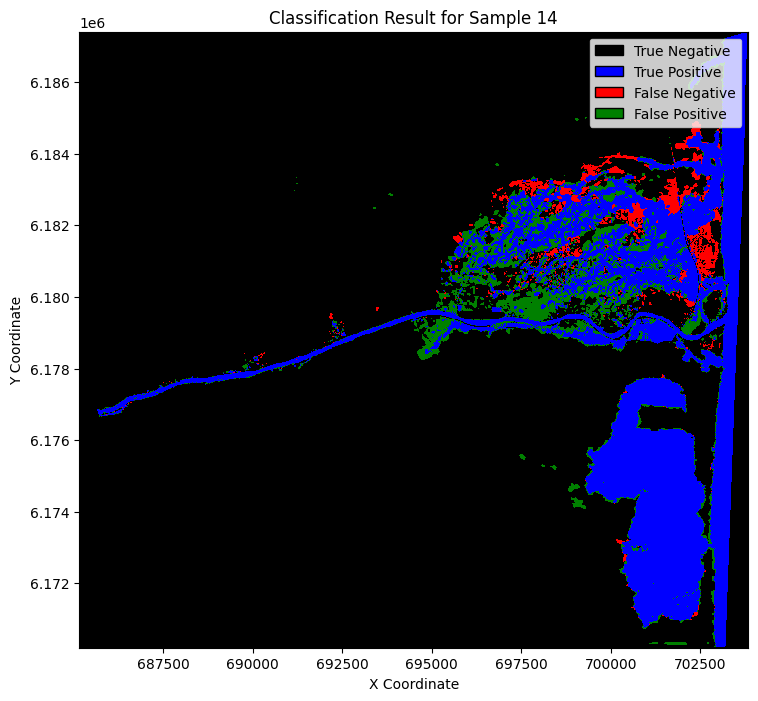

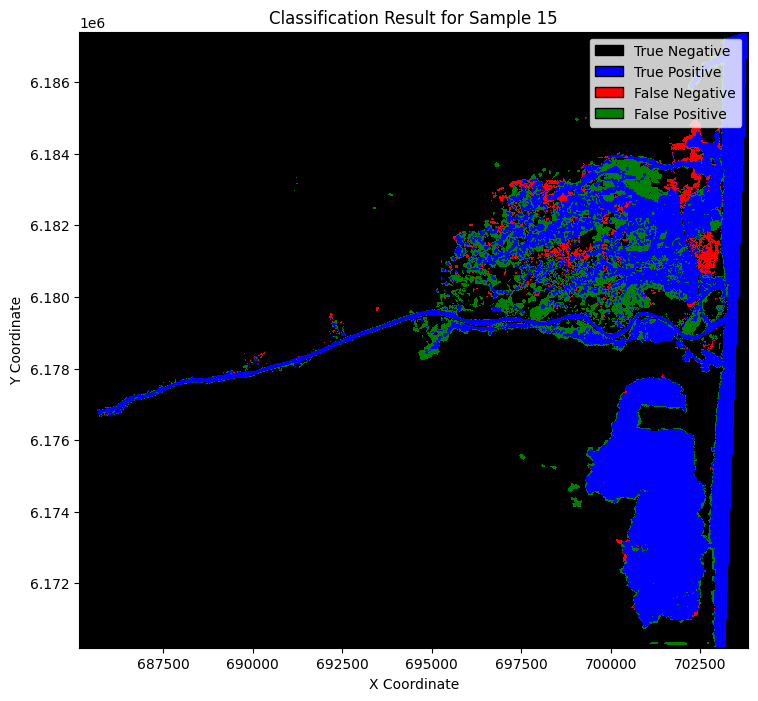

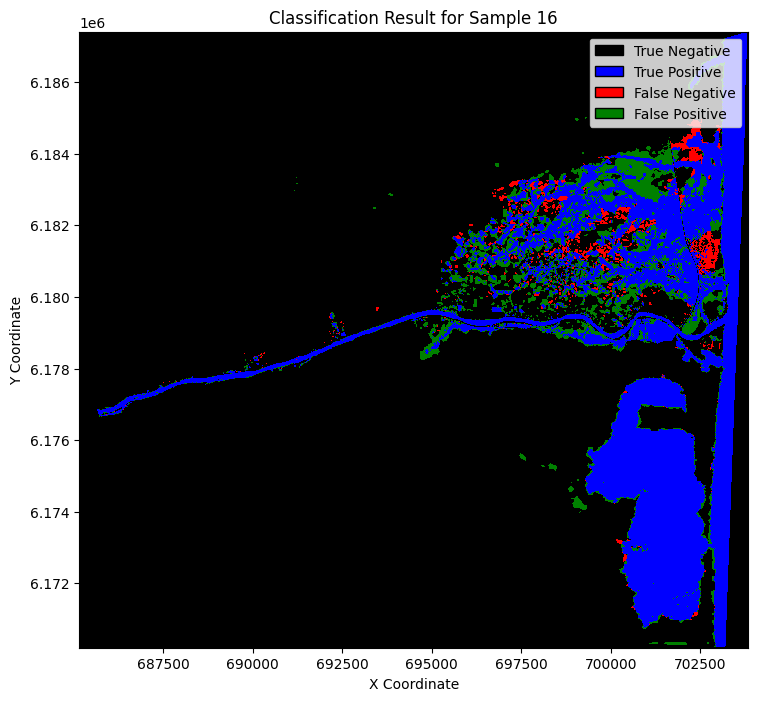

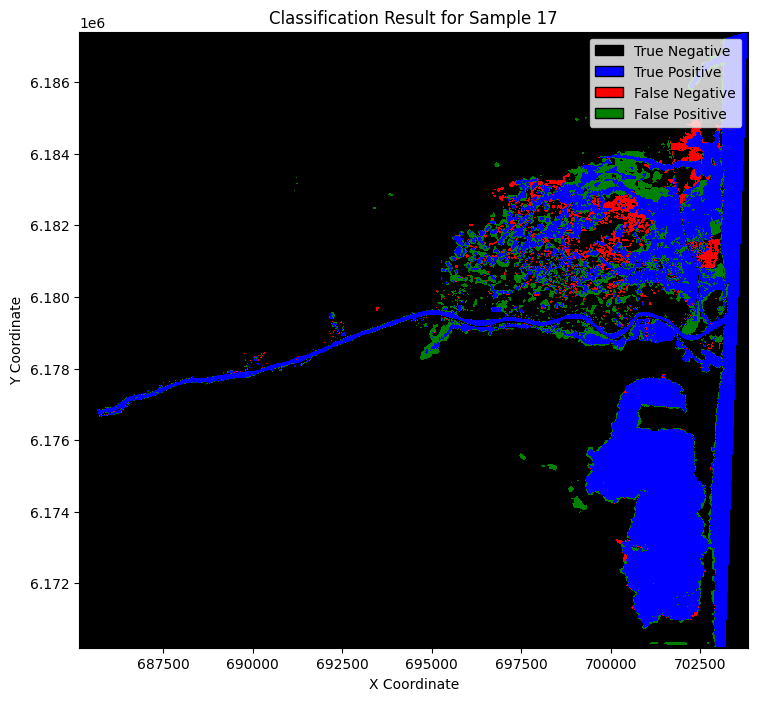

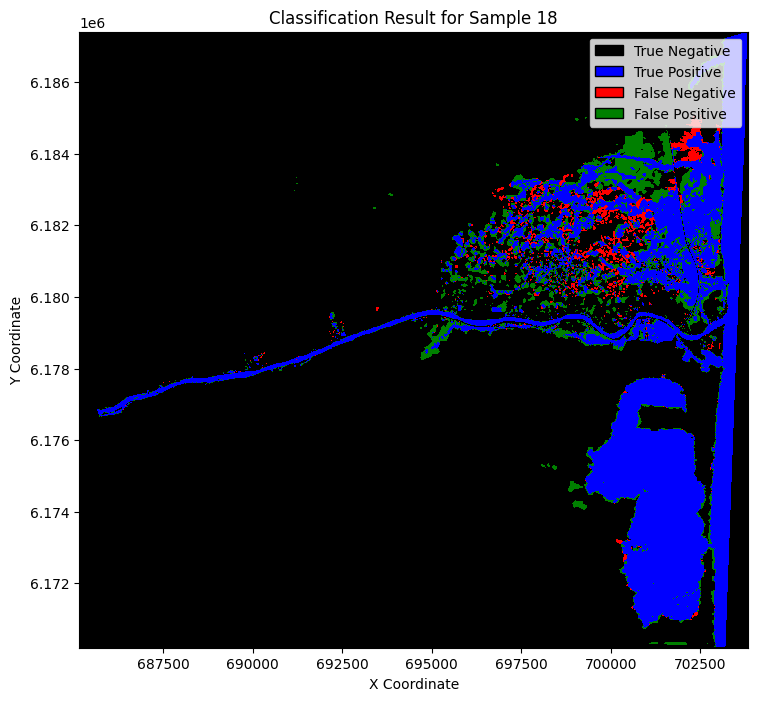

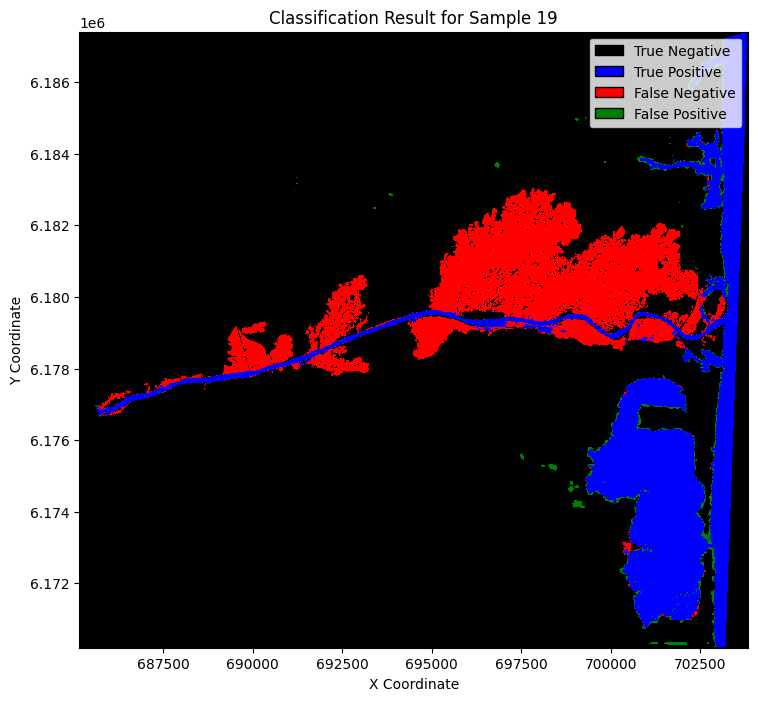

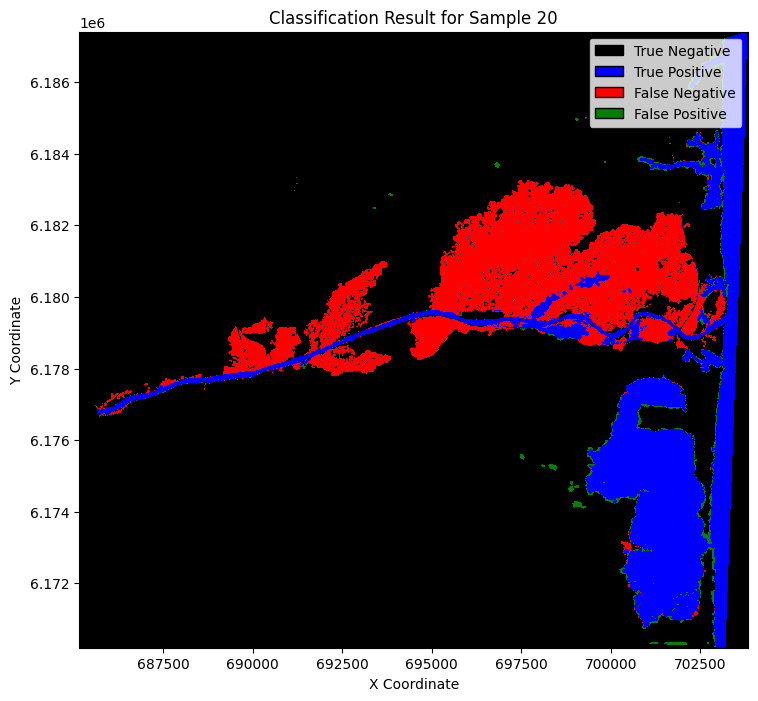

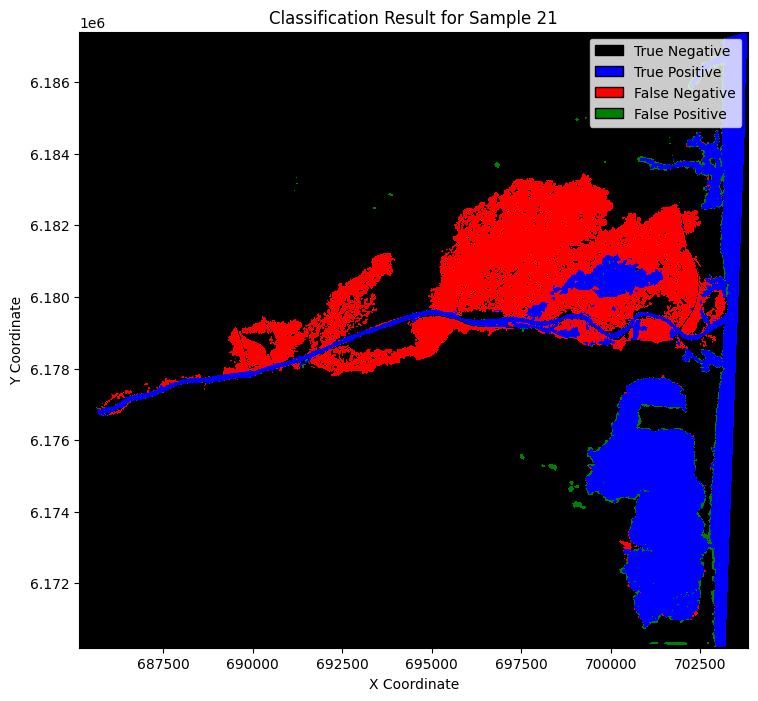

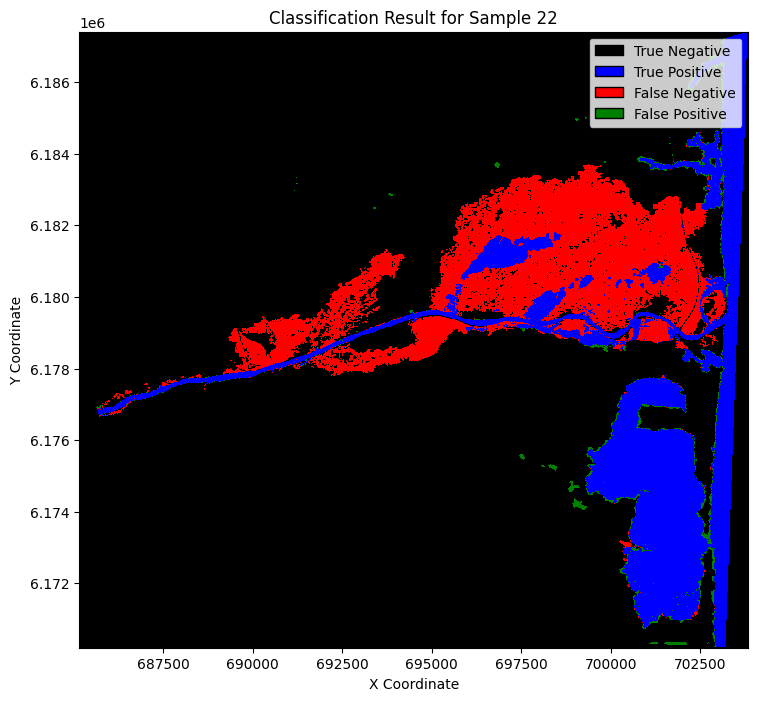

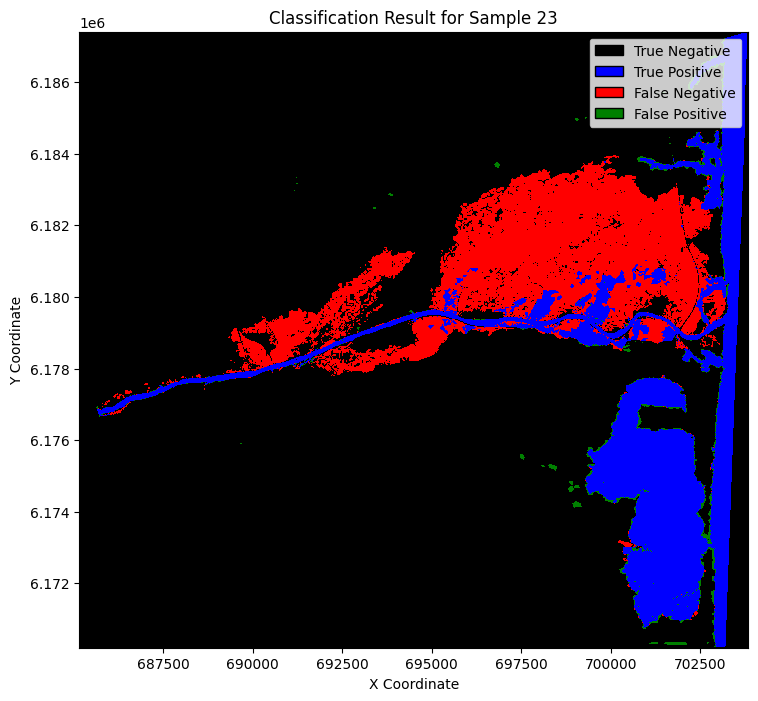

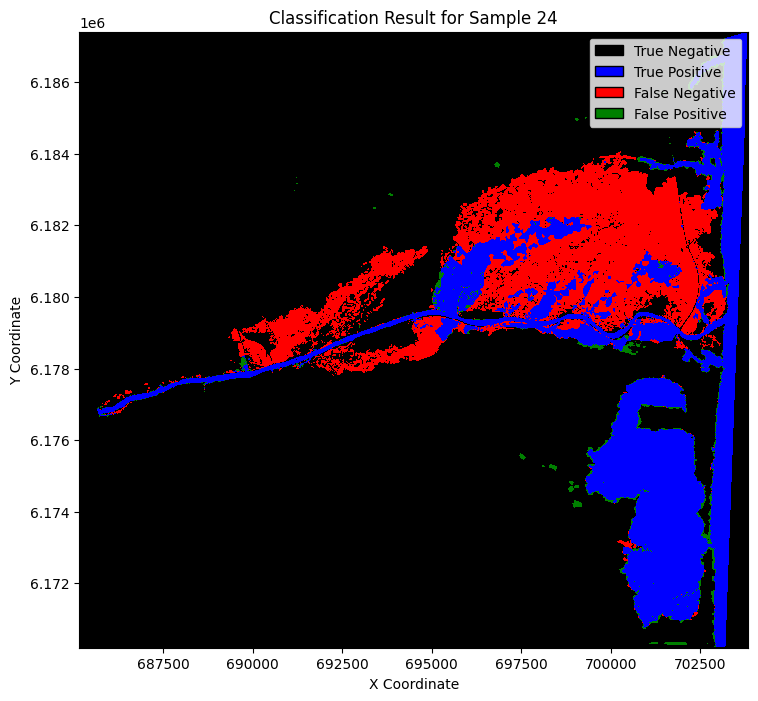

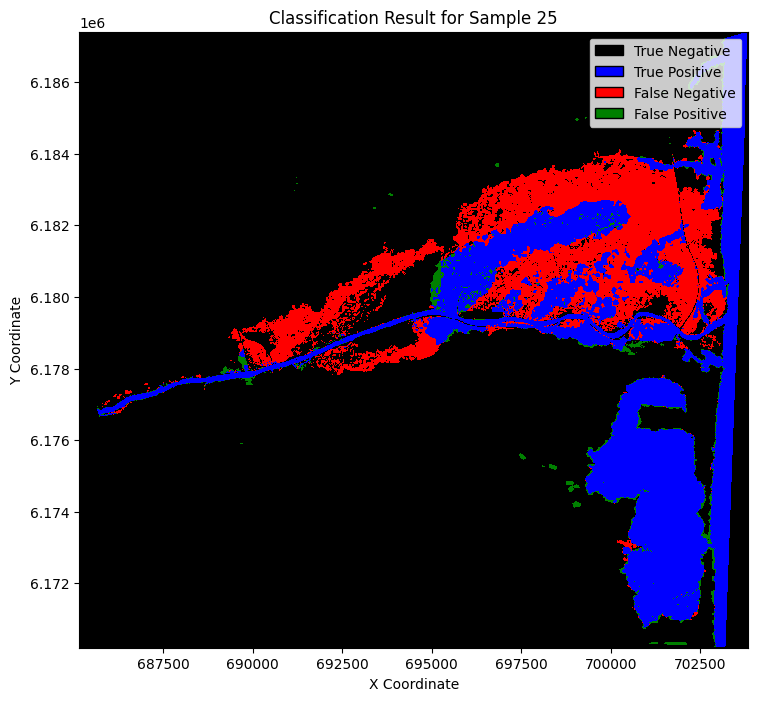

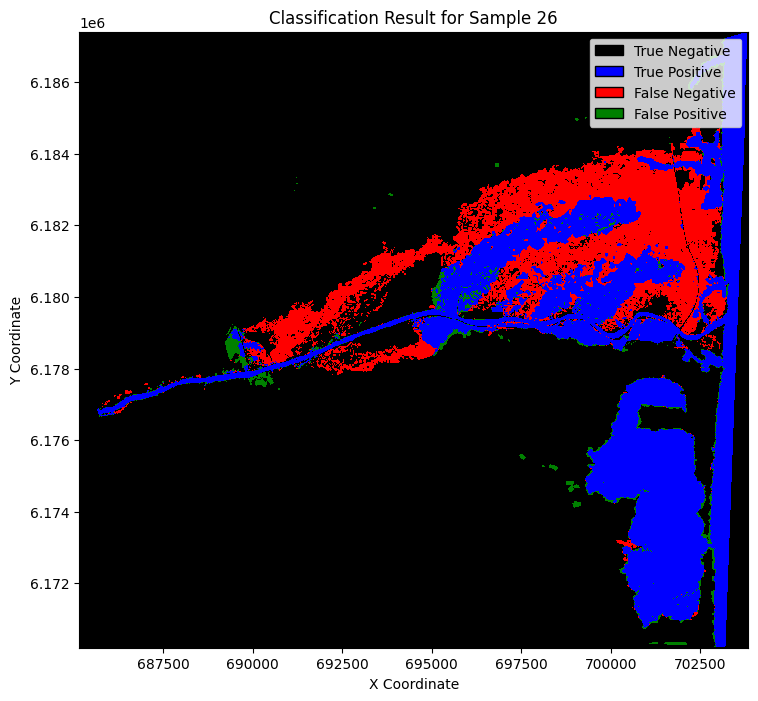

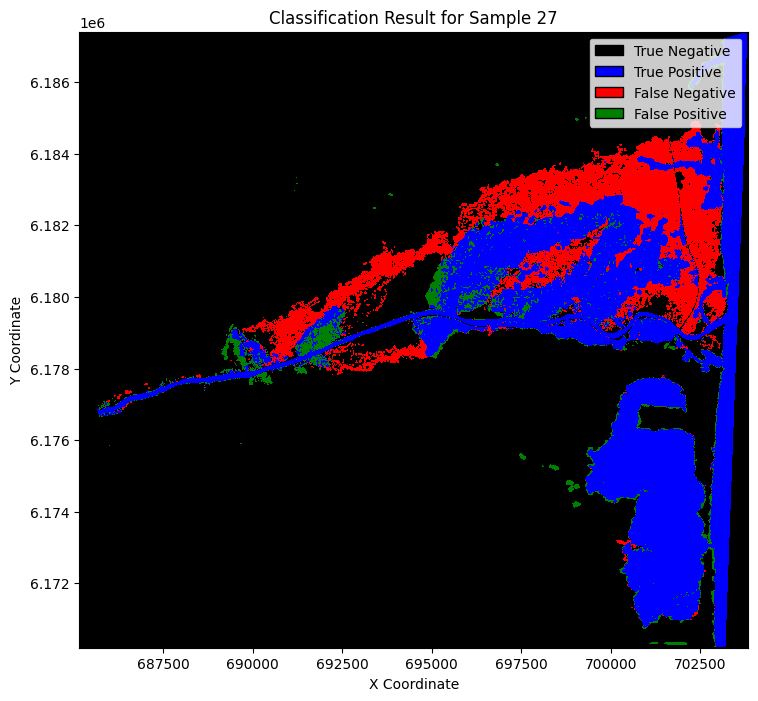

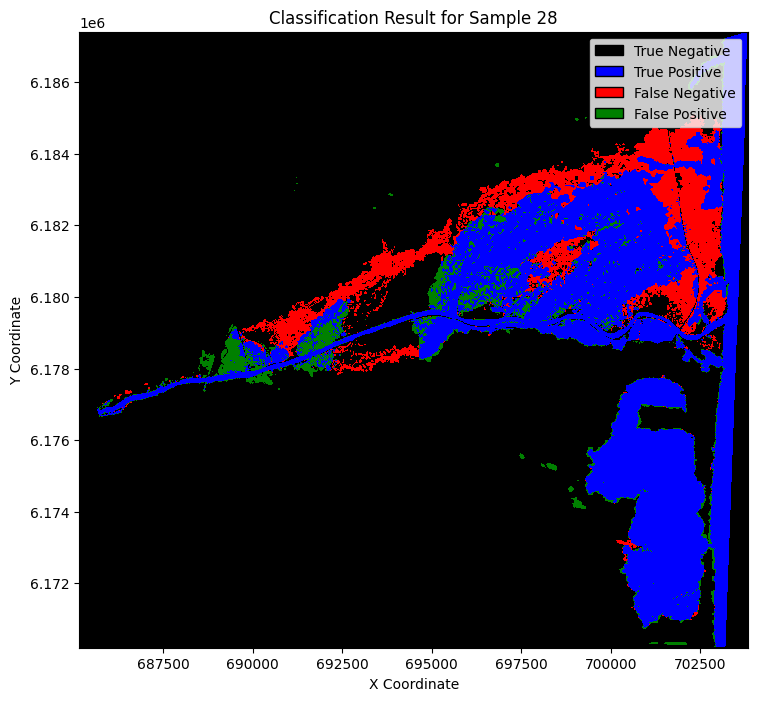

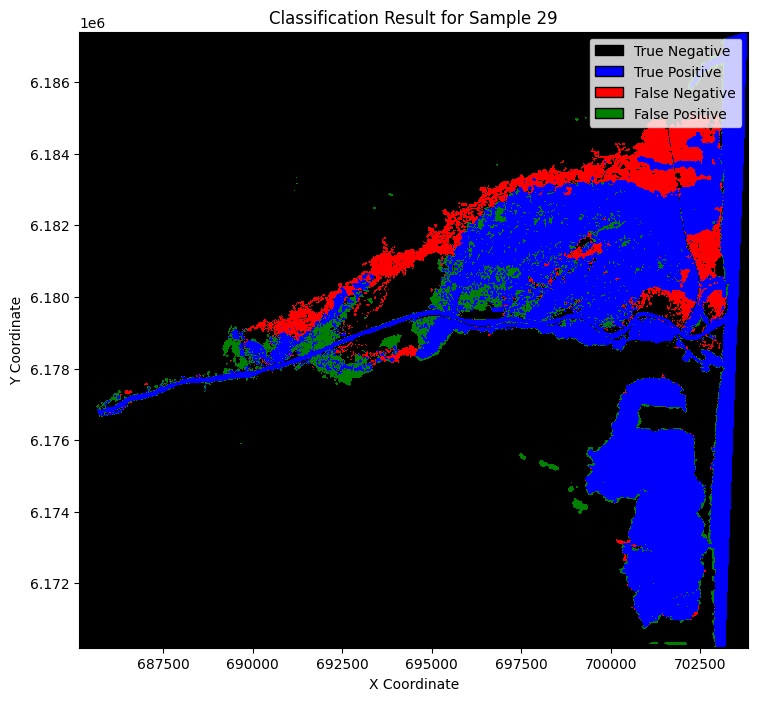

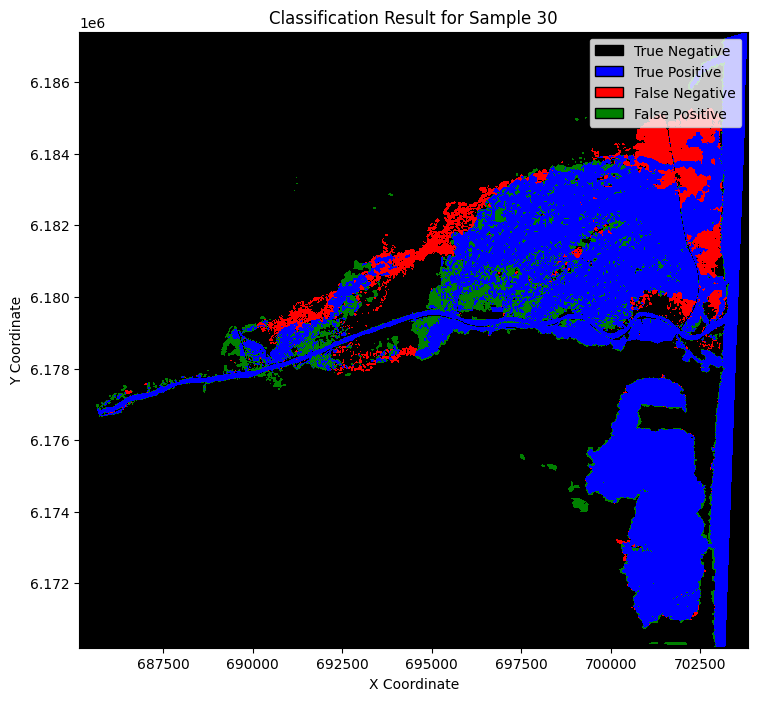

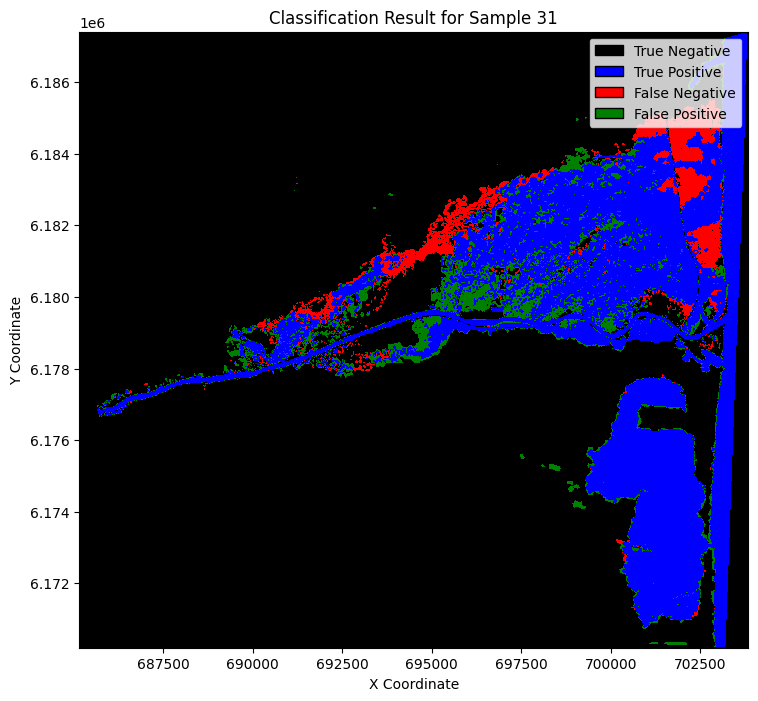

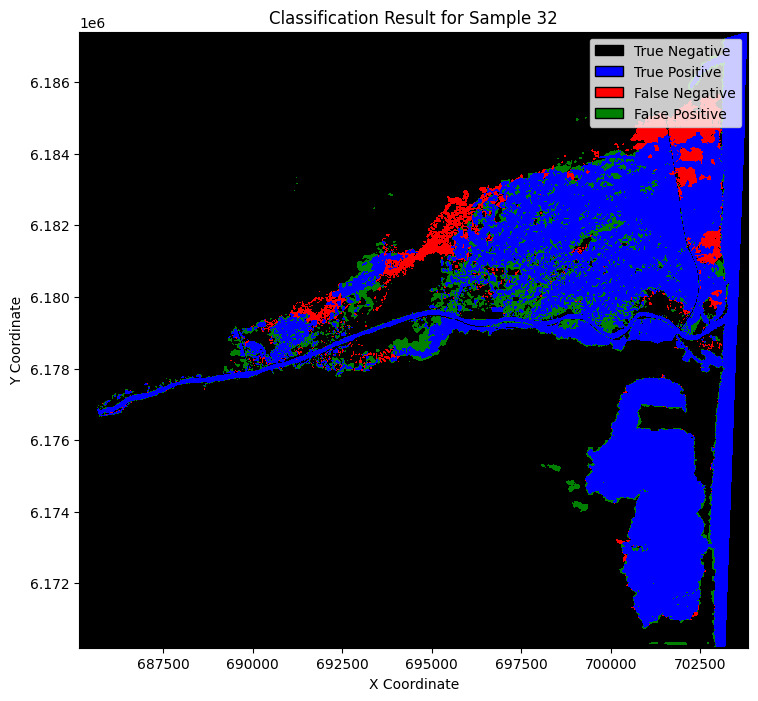

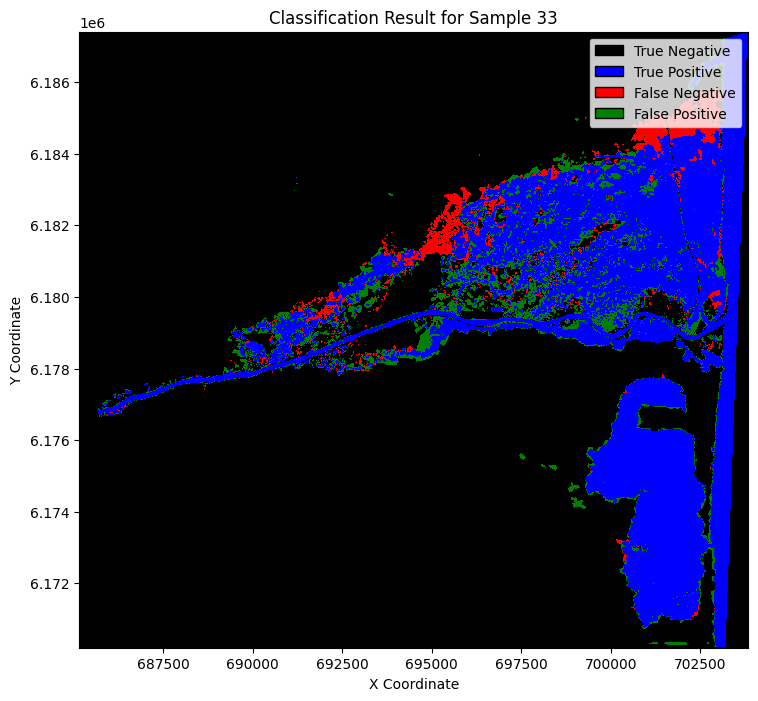

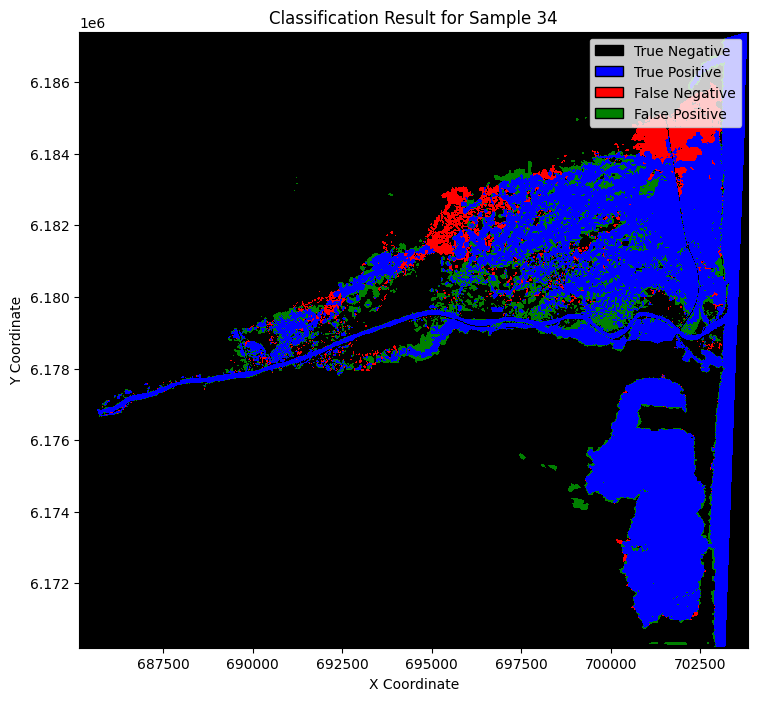

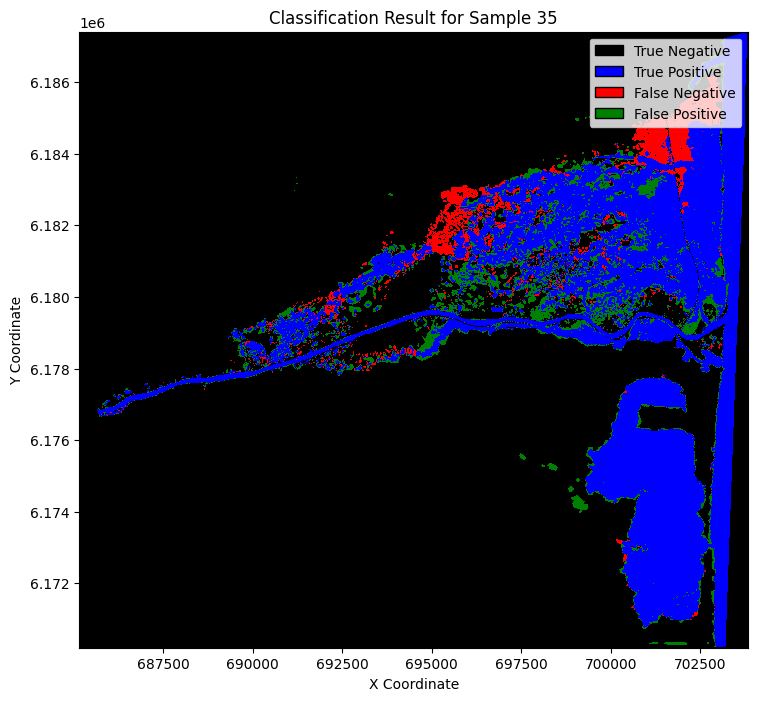

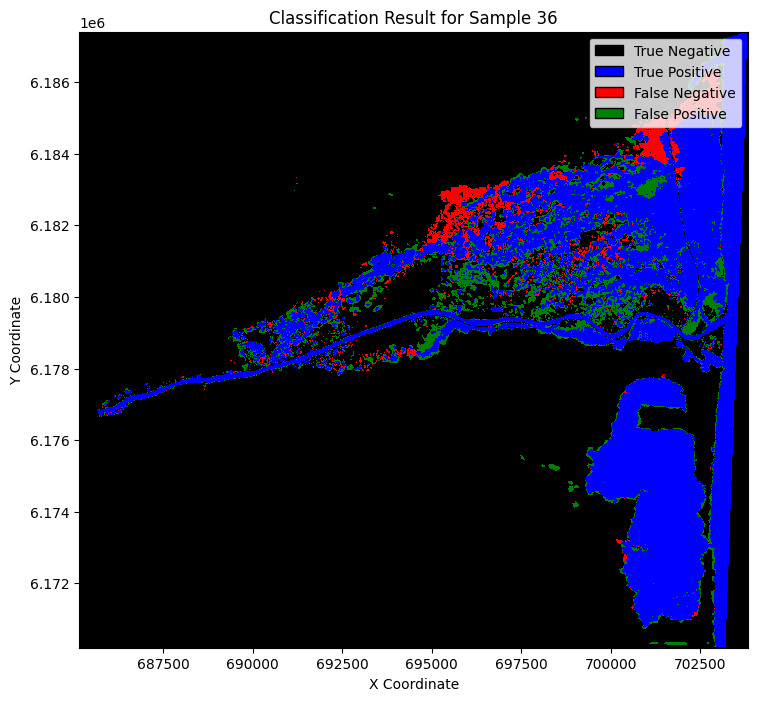

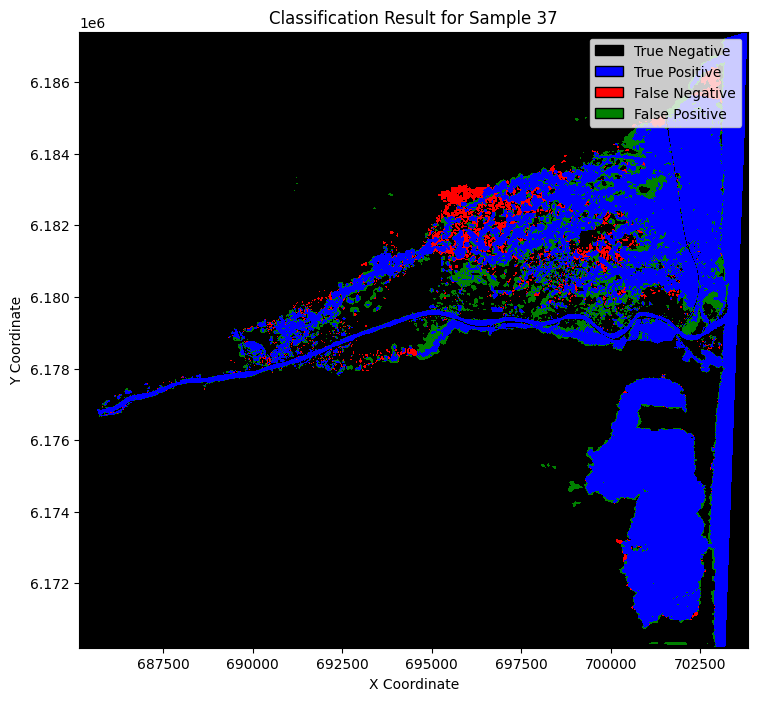

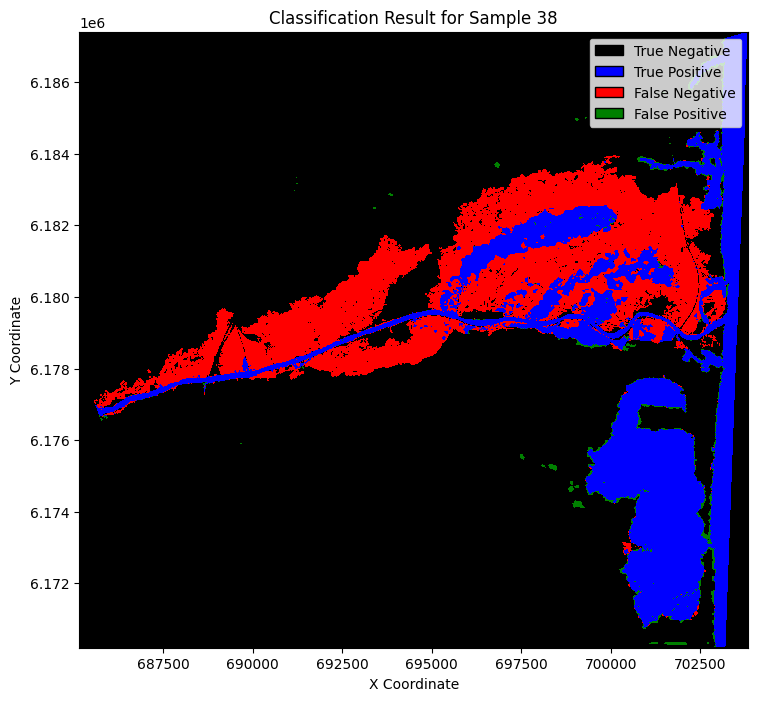

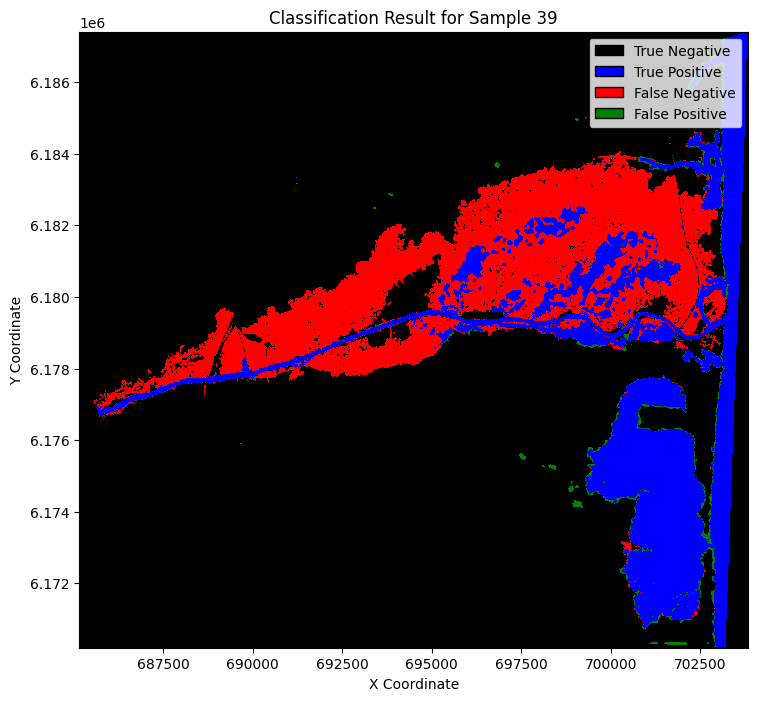

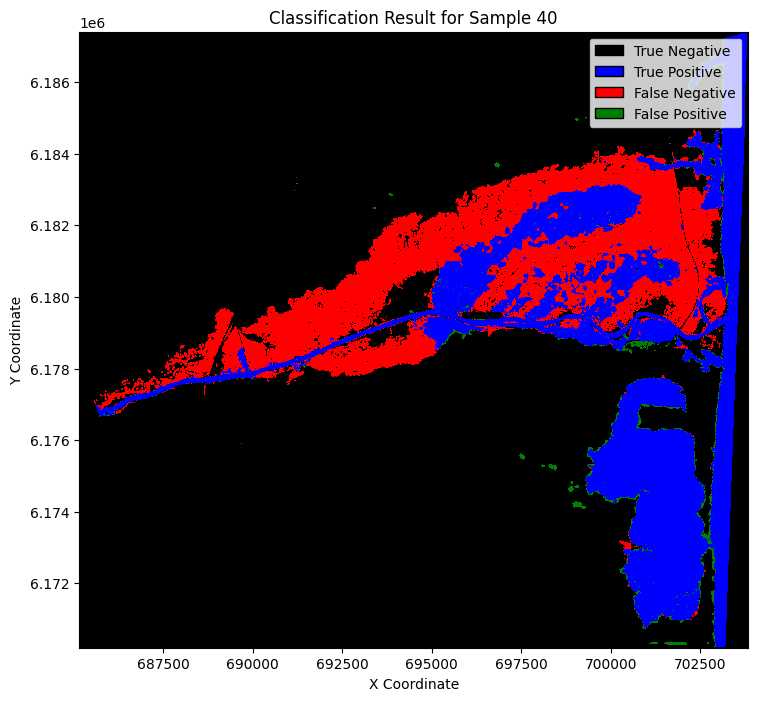

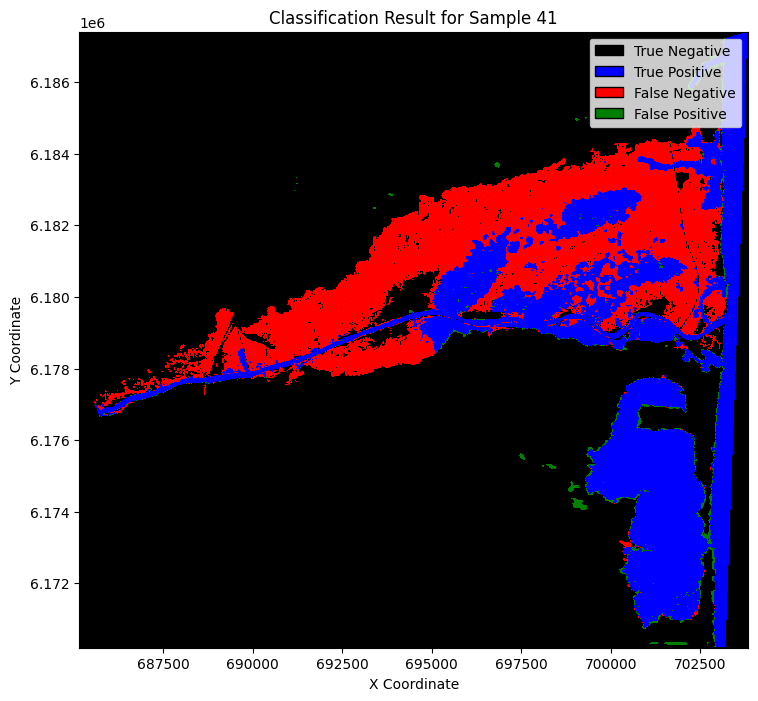

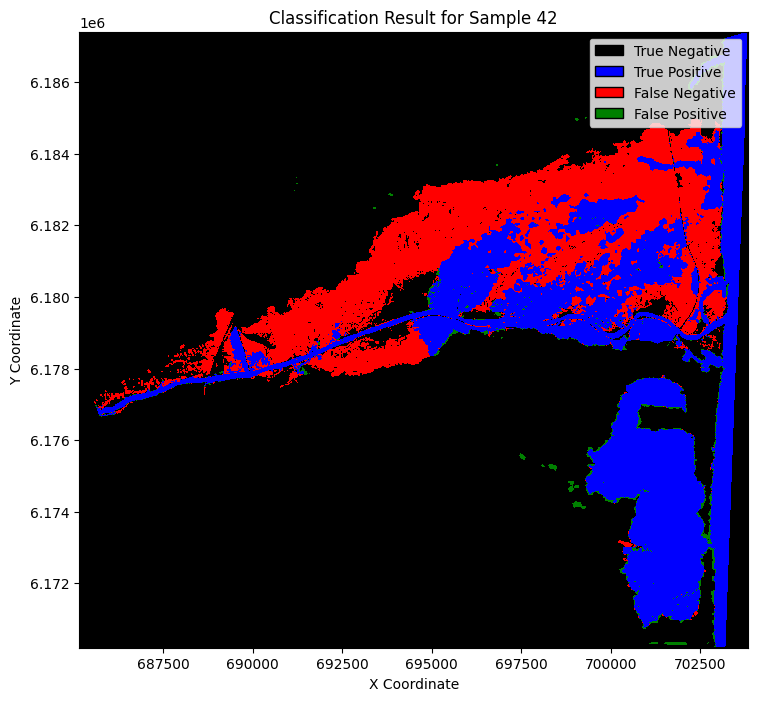

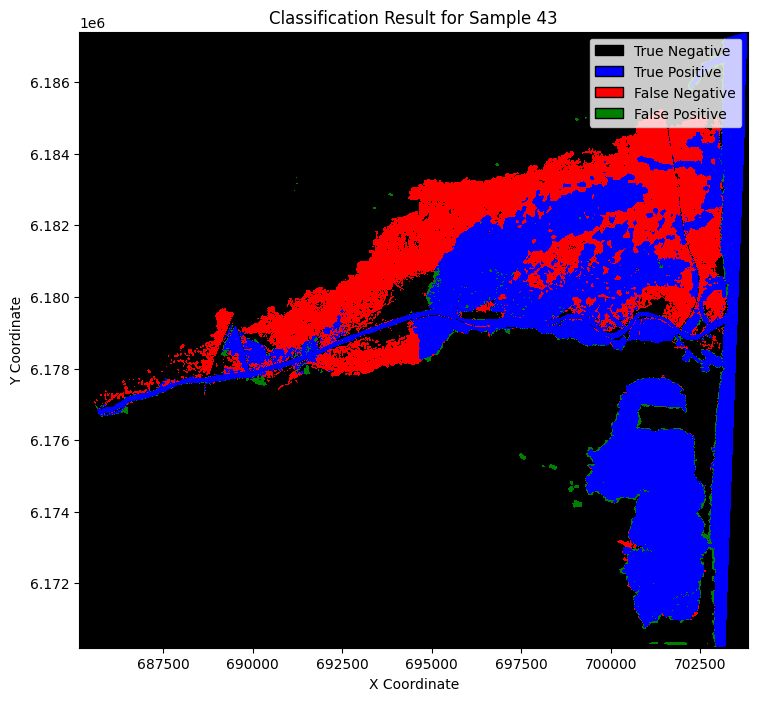

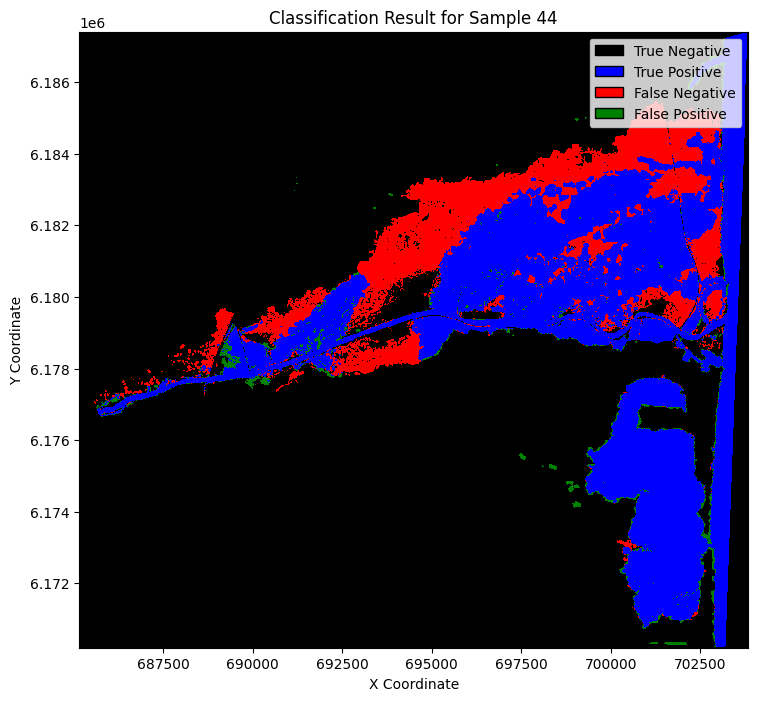

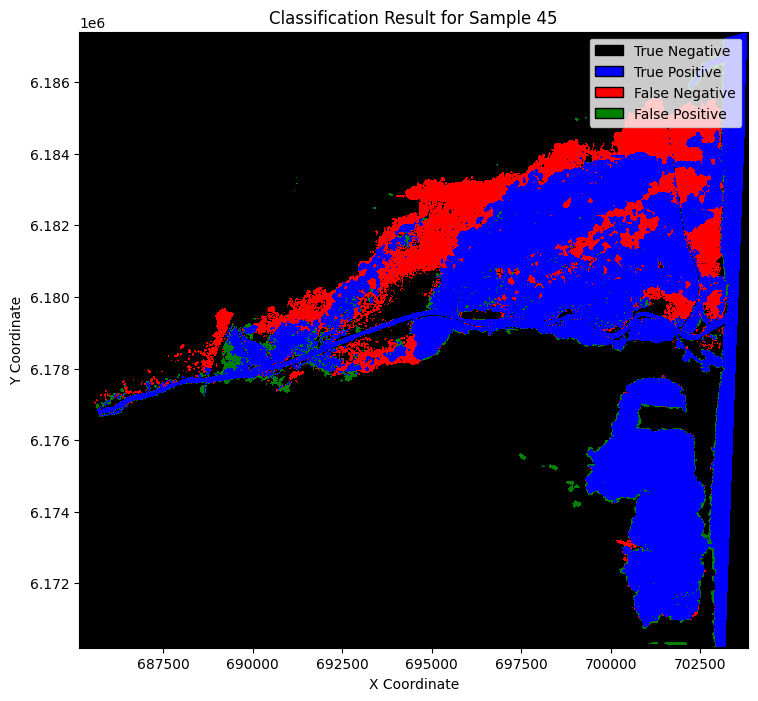

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x4002043a29e0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 54, in _cb
    def _cb(arg):
KeyboardInterrupt: 


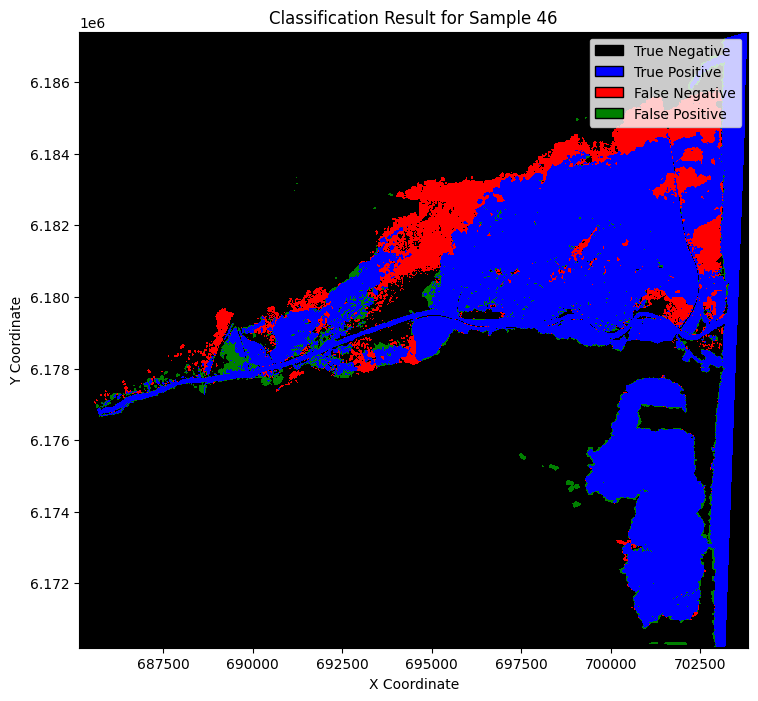

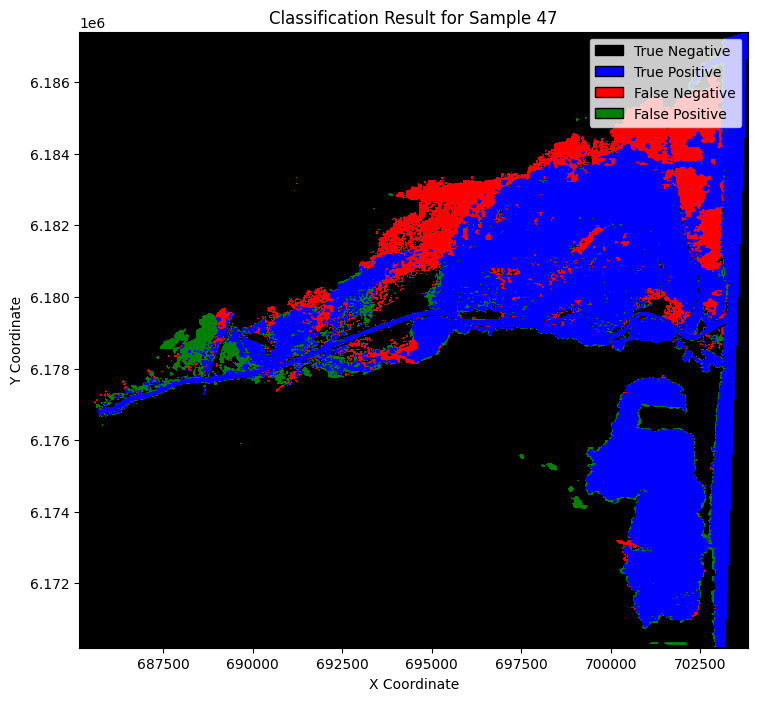

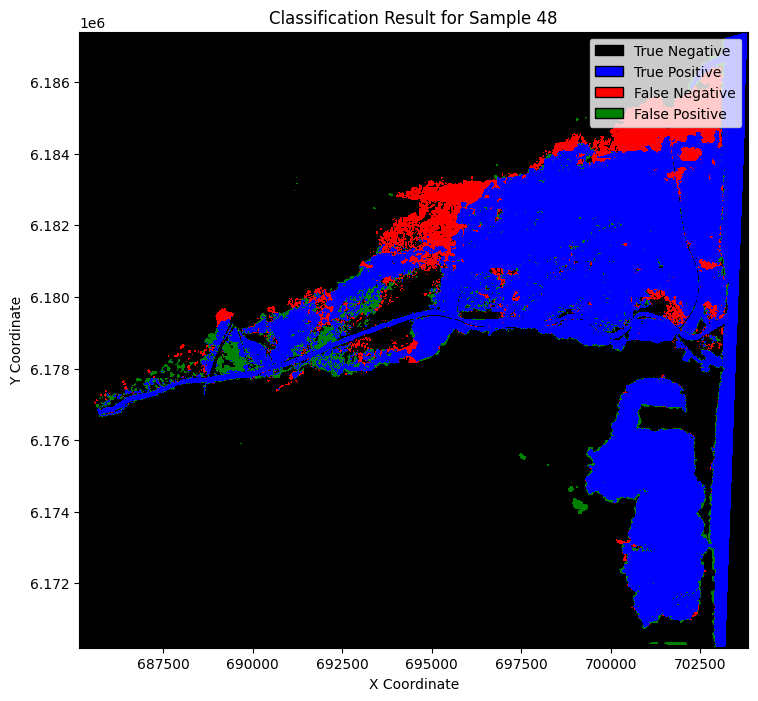

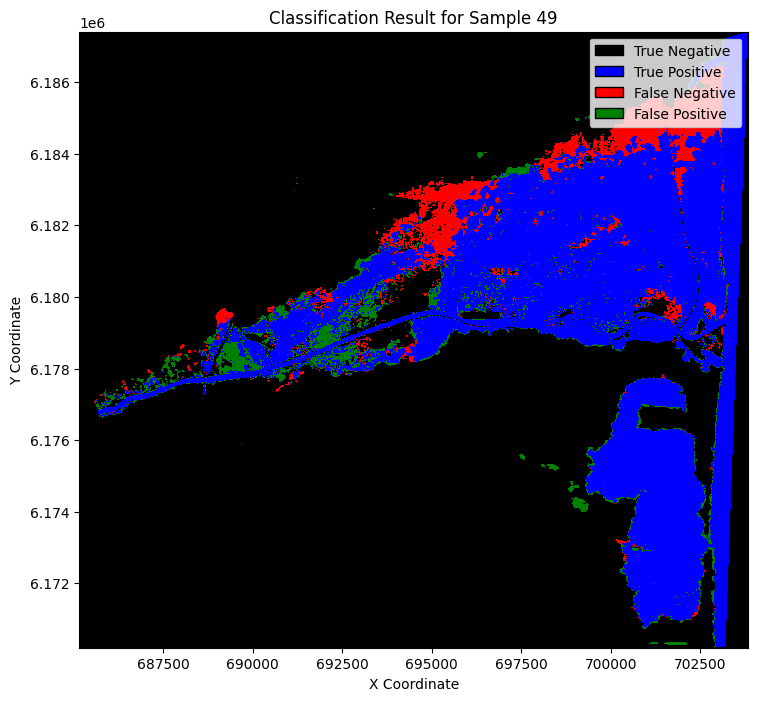

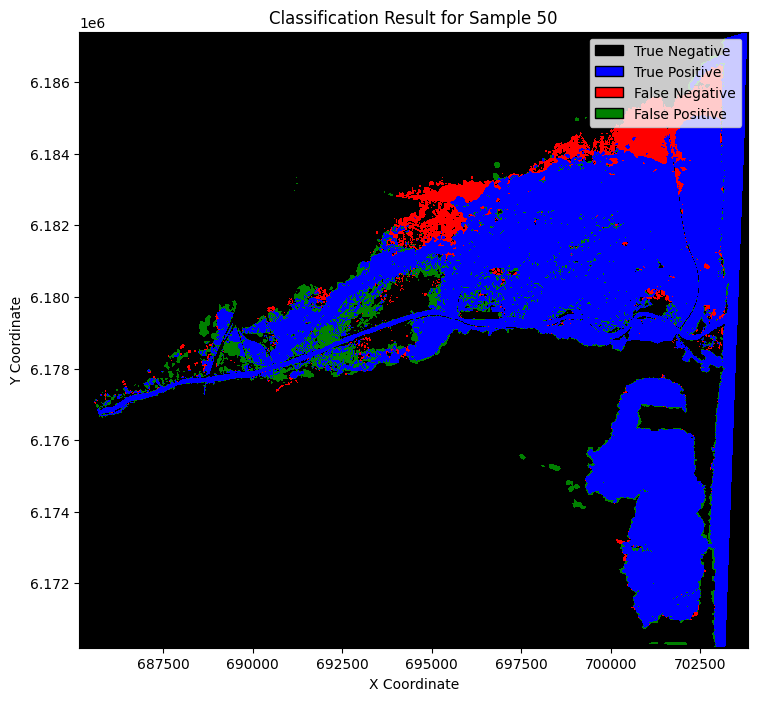

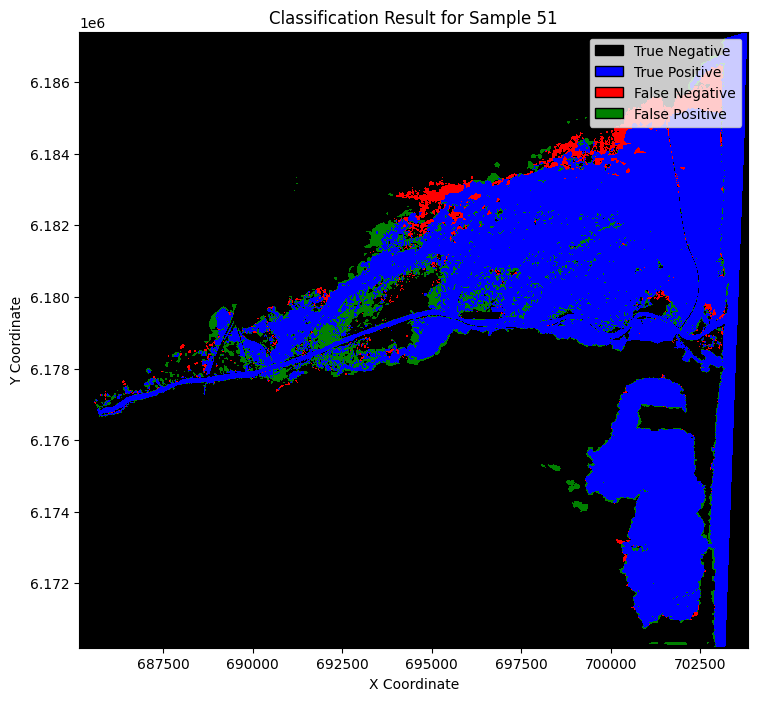

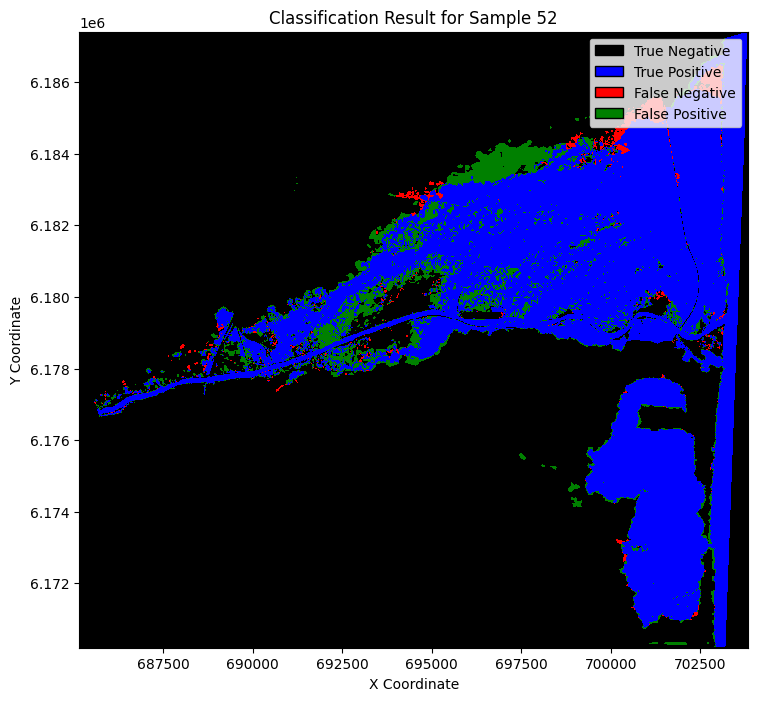


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x40020af88550> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

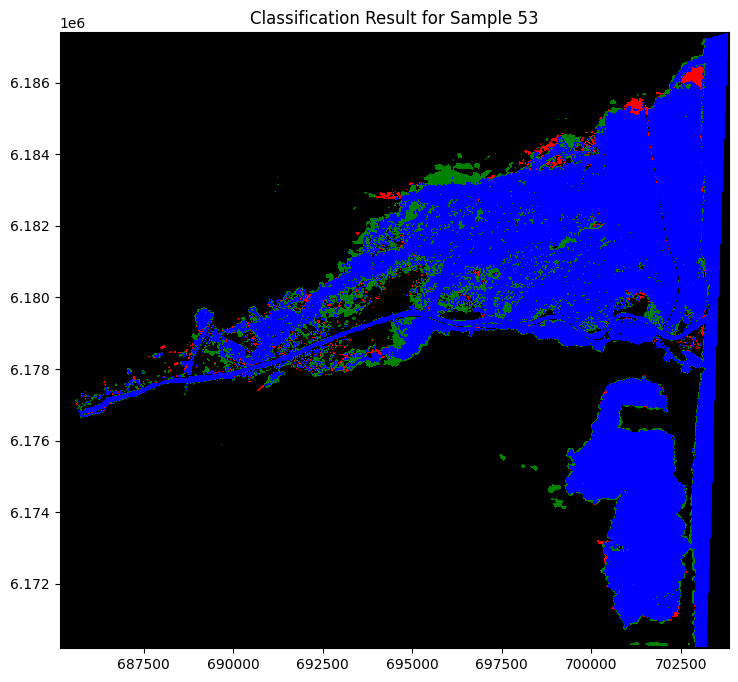

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

def classify_prediction(pred_interp, gd_interp, epsilon):
    """Classify pixels based on prediction and ground truth."""
    tp = (pred_interp >= epsilon) & (gd_interp >= epsilon)
    fn = (pred_interp < epsilon) & (gd_interp >= epsilon)
    fp = (pred_interp >= epsilon) & (gd_interp < epsilon)
    
    color_codes = np.zeros_like(pred_interp, dtype=int)
    color_codes[tp] = 1  # True Positive
    color_codes[fn] = 2  # False Negative
    color_codes[fp] = 3  # False Positive
    
    return color_codes

def plot_data(ax, data, title, cmap, norm):
    """Plot interpolated data with a given colormap."""
    ax.set_title(title)
    pcm = ax.pcolormesh(grid_x, grid_y, data, shading='auto', cmap=cmap, norm=norm)
    ax.set_aspect('equal')
    return pcm

# Visualization Parameters
epsilon = 0.05  # Threshold for classification
cmap = ListedColormap(['black', 'blue', 'red', 'green'])
bounds = [0, 1, 2, 3, 4]
norm = BoundaryNorm(bounds, cmap.N)

# For each sample, classify and plot
for idx, (projected_pred, fine_grid) in enumerate(zip(projected_predi, fine_gd_grid)):
    # Extract the 0th variable (h variable)
    pred_h = projected_pred[..., 0]
    fine_h = fine_grid[..., 0]
    
    # Classify the predictions
    classified_data = classify_prediction(pred_h, fine_h, epsilon)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    pcm = plot_data(ax, classified_data, f'Classification Result for Sample {idx}', cmap, norm)
    
    # Create a custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='black', edgecolor='k', label='True Negative'),
        Patch(facecolor='blue', edgecolor='k', label='True Positive'),
        Patch(facecolor='red', edgecolor='k', label='False Negative'),
        Patch(facecolor='green', edgecolor='k', label='False Positive')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()


In [23]:
print(np.mean(L1_errors))
print(np.mean(CSI_scores))

0.034821073114311096
0.6792956116522156


In [24]:
print(CSI_scores)

[0.6550990218572637, 0.6273936939542957, 0.5982536980917985, 0.6035051007062516, 0.5957840708868517, 0.5652369380315917, 0.5676729528901097, 0.5608422301304864, 0.6860414419789348, 0.6486303650972066, 0.6366672249905783, 0.5925427404353962, 0.6659457333857648, 0.6826296063606231, 0.6685082275607066, 0.6870466083727753, 0.6951573678369891, 0.6886668419668682, 0.6750427768271816, 0.5454619940538895, 0.4875878986099755, 0.46572567950467, 0.4845180331149017, 0.52106099263467, 0.6524425767632873, 0.6622759922985783, 0.6905885744140379, 0.7318719144888808, 0.7425903299005062, 0.7172188443562063, 0.7148103590198189, 0.7223231091984046, 0.7249642940180024, 0.7245417782679481, 0.7369151205977645, 0.7329311386564623, 0.7270337806571032, 0.7234360410830999, 0.6314403643609451, 0.6801434876706259, 0.6163784435954153, 0.6724783885041439, 0.6892724543802828, 0.762235296882712, 0.7337013057586909, 0.7329136888804013, 0.7878073864857397, 0.7901667087273428, 0.7612354144540355, 0.7687219762163366, 0.80

In [25]:
print(np.mean(CSI_scores[::4]))
print(np.mean(L1_errors[::4]))

0.6883115626849868
0.03428277990794896


In [ ]:
for i in range(len(predict)):
    
    
    data_predict = projected_predi[i][:,0]
    data_groundtruth = fine_gd[i][:,0]

    # Create colormaps
    data_cmap = plt.cm.viridis  # Example colormap, adjust as needed
    norm_data = plt.Normalize(vmin=min(np.min(data_predict), np.min(data_groundtruth)), 
                              vmax=max(np.max(data_predict), np.max(data_groundtruth)))
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(36, 18), constrained_layout=True)

    # Prediction plot
    contour1 = axes[0].tricontourf(triangulation_fine, data_predict, levels=20, cmap=data_cmap,norm=norm_data)
    fig.colorbar(contour1, ax=axes[0], label='Normalized Value')
    axes[0].set_title("Prediction")

    # Groundtruth plot
    contour2 = axes[1].tricontourf(triangulation_fine, data_groundtruth, levels=20, cmap=data_cmap,norm=norm_data)
    fig.colorbar(contour2, ax=axes[1], label='Normalized Value')
    axes[1].set_title("Groundtruth")


    # Show the enhanced plot
    plt.show()

In [ ]:
def calculate_csi(predictions, observations, epsilon):
    """
    Calcule le Critical Success Index (CSI) entre deux tableaux de prédictions et d'observations.
    
    Parameters:
    predictions (numpy.ndarray): Un tableau numpy contenant les prédictions.
    observations (numpy.ndarray): Un tableau numpy contenant les observations réelles.
    epsilon (float): Le seuil pour déterminer les valeurs binaires (0 ou 1).
    
    Returns:
    float: Le Critical Success Index (CSI).
    """
    
    # Binariser les prédictions et les observations selon le seuil epsilon
    binary_predictions = (predictions >= epsilon).astype(int)
    binary_observations = (observations >= epsilon).astype(int)
    
    # Calculer les True Positives, False Positives et False Negatives
    TP = np.sum((binary_predictions == 1) & (binary_observations == 1))
    FP = np.sum((binary_predictions == 1) & (binary_observations == 0))
    FN = np.sum((binary_predictions == 0) & (binary_observations == 1))
    
    # Calculer le CSI
    csi = TP / (TP + FP + FN)
    
    return csi

In [ ]:
epsilon = 5e-2
calculate_csi(projected_predi[0][:,0],fine_gd[0][:,0],epsilon)

In [ ]:
Mean_CSI = 0.0
epsilon = 1e-2
for j in range(len(projected_predi)):
    if j%2==0 :
        Mean_CSI += calculate_csi(projected_predi[j][:,0],fine_gd[j][:,0],epsilon)
print(Mean_CSI/len(projected_predi))

In [ ]:
# Data
label_x = ['base', 'x2', 'x4', 'x8', 'x16']
no_multi = [0.55, 0.68, 0.69, 0.62, 0.66]
multi = [0.43, 0.63, 0.71, 0.70, 0.66]

# Set the style
#sns.set(style='whitegrid')

# Create a new figure with a defined size
plt.figure(figsize=(10, 6))

# Plotting with markers and line styles
plt.plot(label_x, no_multi, marker='o', linestyle='-', linewidth=2, label='Classic MGN')
plt.plot(label_x, multi, marker='s', linestyle='--', linewidth=2, label='MGN with Multimesh')

# Title and labels with increased font size
plt.title("CSI of # Mesh Models Projected on Fine Mesh (15 Steps Ahead)", fontsize=16)
plt.xlabel("Used Training Mesh", fontsize=14)
plt.ylabel("CSI", fontsize=14)

# Set y-axis to logarithmic scale
#plt.yscale('log')

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend with increased font size
plt.legend(fontsize=12)

# Add grid with custom style
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
#import seaborn as sns

# Data
label_x = ['base', 'x2', 'x4', 'x8', 'x16']

one_step = [0.0045,0.0089,0.0088,0.018535,0.027745]
six_steps = [0.0155,0.0171,0.0192,0.0240,0.0312]
twelve_steps = [0.025,0.0308,0.0370,0.0357,0.0405]

six_steps_from_start = [0.0111,0.0123,0.01269,0.01621,0.02402]
twelve_steps_from_start = [0.035547,0.03709,0.03655,0.03793,0.04349]
# Set the style
#sns.set(style='whitegrid')

# Create a new figure with a defined size
plt.figure(figsize=(10, 6))

# Plotting with markers and line styles
plt.plot(label_x, one_step, marker='o', linestyle='-', linewidth=2, label='$1$ steps ahead')
plt.plot(label_x, six_steps, marker='o', linestyle='-', linewidth=2, label='$6$ steps ahead')
plt.plot(label_x, twelve_steps, marker='o', linestyle='-', linewidth=2, label='$12$ steps ahead')

# Title and labels with increased font size
plt.title("$L_1$ Norm of Mesh Models Projected on regular Grid", fontsize=16)
plt.xlabel("Used Training Mesh", fontsize=14)
plt.ylabel("Norm $L_1$", fontsize=14)

# Set y-axis to logarithmic scale
plt.yscale('log')

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend with increased font size
plt.legend(fontsize=12)

# Add grid with custom style
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
#import seaborn as sns

# Data
label_x = ['base', 'x2', 'x4', 'x8', 'x16']

one_step = [0.951,0.8939,0.89536,0.8191,0.76222]
six_steps = [0.832,0.818,0.797,0.776,0.744]
twelve_steps = [0.665,0.653,0.6337221,0.66654,0.6571]

six_steps_from_start = [0.8350,0.82244,0.79263,0.77794,0.73054]
twelve_steps_from_start = [0.5473,0.5445,0.5468,0.6106,0.6104]
# Set the style
#sns.set(style='whitegrid')

# Create a new figure with a defined size
plt.figure(figsize=(10, 6))

# Plotting with markers and line styles
plt.plot(label_x, one_step, marker='o', linestyle='-', linewidth=2, label='$1$ steps ahead')
plt.plot(label_x, six_steps, marker='o', linestyle='-', linewidth=2, label='$6$ steps ahead')
plt.plot(label_x, twelve_steps, marker='o', linestyle='-', linewidth=2, label='$12$ steps ahead')

# Title and labels with increased font size
plt.title("CSI of # Mesh Models Projected on Fine Mesh", fontsize=16)
plt.xlabel("Used Training Mesh", fontsize=14)
plt.ylabel("CSI", fontsize=14)

# Set y-axis to logarithmic scale
plt.yscale('log')

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend with increased font size
plt.legend(fontsize=12)

# Add grid with custom style
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
#import seaborn as sns

# Data
label_x = ['base', 'x2', 'x4', 'x8', 'x16']


six_steps_from_start = [0.8350,0.82244,0.79263,0.77794,0.73054]
twelve_steps_from_start = [0.5473,0.5445,0.5468,0.6106,0.6104]
# Set the style
#sns.set(style='whitegrid')

# Create a new figure with a defined size
plt.figure(figsize=(10, 6))

# Plotting with markers and line styles
plt.plot(label_x, six_steps_from_start, marker='o', linestyle='-', linewidth=2, label='$6$ steps ahead')
plt.plot(label_x, twelve_steps_from_start, marker='o', linestyle='-', linewidth=2, label='$12$ steps ahead')

# Title and labels with increased font size
plt.title("CSI of # Mesh Models Projected on Fine Mesh (only from the first timestep)", fontsize=16)
plt.xlabel("Used Training Mesh", fontsize=14)
plt.ylabel("CSI", fontsize=14)

# Set y-axis to logarithmic scale
plt.yscale('log')

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend with increased font size
plt.legend(fontsize=12)

# Add grid with custom style
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()